
<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
 <h2>Mentoría: Clasificación de Tumoresferas </h2>
</center>



<a name="exploratory_data_analysis"></a>
#### **Práctico de Análisis Exploratorio y Visualización**



### Descripción de los datos: 

Se tratan de datos procesados en el [Grupo de Materia Condensada](https://ri.conicet.gov.ar/handle/11336/102) (FaMAF-UNC, IFEG-CONICET) en colaboración con el Laboratorio de Células Madre del [IBYME-CONICET](https://www.ibyme.org.ar/laboratorios/49/celulas-madre) a partir de imágenes tomadas usando un microscopio óptico invertido común.


Para extraer la información estructurada a partir de las imágenes se hizo uso del programa Fiji, que es un paquete de procesamiento de imágenes, distribución muy completa del programa [ImageJ](https://www.medicinatv.com/profesional/reportajes/una-plataforma-abierta-revoluciona-el-procesamiento-de-imagenes-biomedicas-4596/), que es ampliamente utilizado para procesar
imágenes médicas. 

De acuerdo a la documentación del programa,
es posible contar y medir objetos si conocemos la escala en la cual se han
llevado a cabo dichas imágenes, en este caso, a cuántos $\mu$m equivale un
píxel.
Para llevar a cabo el procedimiento detallado en la [documentación](https://imagej.nih.gov/ij/docs/guide/146-30.html#sub:Analyze-Particles...),
es necesario contar con una imagen umbralizada. 

Se realizó este procedimiento en las 91 imágenes disponibles y se etiquetaron en *esferoides* 'si' y 'no' de acuerdo al criterio de un [experto](https://www.conicet.gov.ar/new_scp/detalle.php?id=43977&datos_academicos=yes), obteniendo 1018 datos.



Importamos las librerías necesarias:

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#sns.set_context("talk")
# por si quieren ver los distintos formatos:
# https://datavizpyr.com/seaborn-set_context-to-adjust-size-of-plot-labels-and-lines/
# https://seaborn.pydata.org/generated/seaborn.set_context.html

import warnings

warnings.filterwarnings("ignore")

from scipy.stats import kurtosis, skew
import scipy.stats
from scipy import stats
from scipy.stats import levene
import math

## Datos


Cargamos los datos de los experimentos realizados desde el día cero al séptimo. 


Ya se encuentran las etiquetas y el valor de las poblaciones celulares estimadas en cada esferoide.

In [207]:
try:
    fiji_datos = pd.read_csv("fiji_datos_0al7mo_labels.csv")
except FileNotFoundError:
    fiji_datos = pd.read_csv("http://www.ccll.com.ar/fiji_datos_0al7mo_labels.csv")

fiji_datos.head()

,labels,Area,X,Y,XM,YM,Perim.,BX,BY,Width,...,FeretY,FeretAngle,MinFeret,AR,Round,Solidity,Esferoide,dia,Diameter,n_diam
0,Esferas_BT474_dia_0_well_1_100X_1_blob_1,324.4440,1129.2718,102.2051,1129.2718,102.2051,67.3603,1118.8859,92.3913,21.0598,...,157,23.4287,19.7011,1.0653,0.9387,0.9500,si,0,20.95640,1.491357
1,Esferas_BT474_dia_0_well_1_100X_1_blob_2,497.5115,1517.5528,126.1022,1517.5528,126.1022,82.8004,1504.7554,113.4511,25.8152,...,192,16.1443,25.1289,1.0475,0.9546,0.9569,si,0,26.00200,2.848733
2,Esferas_BT474_dia_0_well_1_100X_1_blob_3,282.9078,1314.2815,126.0988,1314.2815,126.0988,62.1586,1304.3478,116.8478,19.7011,...,189,15.4222,18.3424,1.0395,0.9620,0.9519,si,0,19.38970,1.181258
3,Esferas_BT474_dia_0_well_1_100X_1_blob_5,500.7421,1189.2841,212.6155,1189.2841,212.6155,84.5571,1175.9511,200.4076,26.4946,...,309,174.1440,25.1359,1.0278,0.9730,0.9493,si,0,25.88475,2.810370
4,Esferas_BT474_dia_0_well_1_100X_1_blob_6,492.8964,1043.0782,247.7667,1043.0782,247.7667,82.0728,1030.5707,235.7337,25.1359,...,353,143.4270,24.4565,1.0186,0.9817,0.9643,si,0,25.33985,2.636596


#### Descripción de las columnas:

   * **labels** (*'nombre_id'*): etiqueta que indica la estructura segmentada seleccionada. 
   * **Area** (*'area'*): columna que indica el área de selección en $\mu$m$^2$.
   * **Perim.** (*'perimetro'*): Es la longitud  del límite exterior de la selección. 
   * **Width** (*'ancho'*) y **Height** (*'altura'*): Es el ancho y la altura del rectángulo mas pequeño que encierra la estructura seleccionada.
   * **Circ.** (*'circulalidad'*): Indica la *circularidad*. Se calcula como 4π × [Area]/[Perimeter]$^2$, que con un valor de 1.0 indica un círculo perfecto. A medida que se acerca a 0.0, indica una forma cada vez más alargada. 
   * Columnas del diámetro de Feret: 
       * **Feret** (*feret*): Indica la distancia más larga entre dos puntos a lo largo del límite de selección. 
       * **MinFeret** (*min_feret*): Indica la distancia mínima entre dos puntos a lo largo del límite de selección.
       * **FeretAngle**: Indica el ángulo del diámetro de Feret.
       * **FeretX** y **FeretY**: son las coordenadas iniciales del diámetro de Feret. 
       * **AR** (*razon_aspecto*): Indica la  razón de aspecto de la elipse ajustada de la estructura seleccionada, es decir, [Eje mayor]/[Eje menor].
       * **Round** (*redondez*): Se calcula como  (4 × [Area] )/ (π × [Major axis]^2) o como la inversa de **AR**. Tiene un rango entre 0 y 1, con 1 indicando un círculo perfecto.
       * **Solidity**: Se calcula como [Area]/[Convex area]. Se calcula el área convexa como el área de una banda elástica envuelta firmemente alrededor de los puntos que definen la selección.
       * **Esferoide** (*esferoide*): etiqueta que indica si la estructura seleccionada califica como esferoide o no
       * **dia**: etiqueta que indica el día en el cual fue realizada la fotografía de origen. 
       * **Diameter** (*diametro*): Se calculó como 0.5*(*Feret*+*MinFeret*)
       * **n_diam** (*poblacion_celular*)


**Modelo para la estimación de la población celular *n_diam*:**

*Se puede hacer una estimación de la cantidad de células en una tumoresfera a partir del volumen $V_1$ de una célula de diámetro $D_1$;*

*Si tenemos una célula, entonces $V_1 = \frac{\pi}{6} D_1^3$ pero si el esferoide tiene $n$ células, entonces tendremos un volumen $V_n = n V_1$ para un diámetro $D_n$ de manera que $V_n =  \frac{\pi}{6} D_n^3$.*

*Si conocemos el diámetro $D_1$ de la célula a un tiempo inicial y el diámetro $D_n$ a un tiempo posterior, reemplazando $V_n$ y $V_1$ podemos estimar la población celular $n$ como: $n  = \frac{V_n}{V_1}= \frac{D_n^3}{D_0^3}.$*






Como utilizamos las imágenes ya segmentadas y recortadas, las columnas *X*, *Y*, *XM*, *YM*, *BX*, *BY*, las coordenadas del diámetro de Feret (*FeretX* y *FeretY*) y el ángulo (*FeretAngle*) **¿suman información al análisis?**
 

Para mas información, pueden explorar la [documentación](https://imagej.nih.gov/ij/docs/guide/146-30.html#sub:Analyze-Particles...).


Pueden ver las imágenes crudas y las individuales (cada fila es una estructura) en la siguiente [carpeta compartida](https://drive.google.com/drive/folders/1aws02t4Z0wSrdbHsQ-cgBkwX8PKLU71c?usp=sharing).

# Análisis de los datos:

*   1) a) Explorar cuántos datos son, ¿cuáles son las columnas? Diferenciar entre categóricas y numéricas.
    
       b) De acuerdo a la descripción de las columnas, definir cuáles son las más importantes y descartar las columnas que no tienen mucha validez para el problema.

*   2) Cambiar el nombre de las columnas en inglés a castellano (están indicadas en paréntesis en la descripción).
*   3) Tratemos de responder alguna de las siguientes preguntas:
    * a) ¿Se trata de una muestra o población?
    * b) ¿Es más probable que sea esferoide a que no lo sea?

    * c) ¿La forma (área, circularidad, diámetro, redondez) influye en la clasificación de *Esferoide*? 
    
    * d) ¿Tales variables son independientes entre sí? 
    * e) ¿La probabilidad de que la redondez ('Round') sea mayor a 0.9 en los clasificados como *Esferoides* = **si** es mayor que los clasificados como *Esferoides* = **no**?. 

* 4) También se puede explorar la muestra por día:
    * a) ¿Cuántos datos hay por día? Hacer gráfico de frecuencias.

    * b) Explorar con diagramas de cajas al menos una columna (ej. Diameter, n_diam, pero pueden animarse a más). 

    * c) Discriminar la(s) columna(s) elegida(s) en *Esferoide* **si** y **no** y ver sus distribuciones. ¿Son distintas?. Describirlas (asimetría, kurtosis, etc..)

    * d) ¿Hay outliers? Hacer con el total y luego discriminando por *Esferoide'* **si** y **no**. ¿Qué pueden implicar biológicamente? Si los eliminan, ¿cuál sería la justificación?

     Si identifican un par, traten de determinar el *'nombre_id'* y las buscamos en las imágenes en la [carpeta compartida](https://drive.google.com/drive/folders/1aws02t4Z0wSrdbHsQ-cgBkwX8PKLU71c?usp=sharing).

    * e) La media de los esferoides=*no* al día 3 es igual que al día 5? Realizar Test de Hipótesis. 
   
    * f) Determinen el intervalo de confianza diario de tal(es) columna(s) para las clasificadas como *'Esferoide'*=**'si'**. Y exploren como utilizarlos como barras de error en el gráfico. 
  
    El intervalo de confianza está dado por $$[LI;LS]$$ donde

    $$ LI = \overline{x}-t_{n-1,1-\alpha/2}\frac{s}{\sqrt n}$$
    $$ LS = \overline{x}+t_{n-1,1-\alpha/2}\frac{s}{\sqrt n}$$

   siendo $s$ la desviación de la distribución y $n$ el tamaño de la muestra.
   Pueden calcular el t-valor en la siguiente [página](https://goodcalculators.com/student-t-value-calculator/) y explorar la librería [scipy.stats.t](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html) .



Interpretar lo que ven en los gráficos en términos generales. ¿Qué creen que sucedió a partir del día 6? 


* 5) ¿Qué otras preguntas se pueden o quisieran plantear? (las que puedan y quieran, las responden, sino planteenlas nomás y las charlamos, quizás se las puede responder con otras herramientas o simplemente son interesantes para tenerlas en cuenta y sería lindo tener otra clase de datos para responderlas.) 


Recordar que es importante como se comunican las respuestas, usar lo que van prendiendo a partir de cada punto y también guitarra ;).

Diseñar e implementar una comunicación a partir de algún ejercicio/s del entregable que les haya llamado la atención y que les parezca relevante en un archivo PDF o ppt.

---

## Ejercicio 1

### a) Exploración inicial: columnas

In [208]:
#Visualizamos la informacion del data set
fiji_datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   labels      1018 non-null   object 
 1   Area        1018 non-null   float64
 2   X           1018 non-null   float64
 3   Y           1018 non-null   float64
 4   XM          1018 non-null   float64
 5   YM          1018 non-null   float64
 6   Perim.      1018 non-null   float64
 7   BX          1018 non-null   float64
 8   BY          1018 non-null   float64
 9   Width       1018 non-null   float64
 10  Height      1018 non-null   float64
 11  Circ.       1018 non-null   float64
 12  Feret       1018 non-null   float64
 13  FeretX      1018 non-null   int64  
 14  FeretY      1018 non-null   int64  
 15  FeretAngle  1018 non-null   float64
 16  MinFeret    1018 non-null   float64
 17  AR          1018 non-null   float64
 18  Round       1018 non-null   float64
 19  Solidity    1018 non-null  

In [209]:
fiji_datos.shape # printing shape

Como podemos ver, el data set consta de 1018 filas, en concordancia con el número de datos mencionado inicialmente, y 24 columnas. Estas son

In [210]:
fiji_datos.columns

Index(['labels', 'Area', 'X', 'Y', 'XM', 'YM', 'Perim.', 'BX', 'BY', 'Width',
       'Height', 'Circ.', 'Feret', 'FeretX', 'FeretY', 'FeretAngle',
       'MinFeret', 'AR', 'Round', 'Solidity', 'Esferoide', 'dia', 'Diameter',
       'n_diam'],
      dtype='object')

In [211]:
fiji_datos.dtypes

labels         object
Area          float64
X             float64
Y             float64
XM            float64
YM            float64
Perim.        float64
BX            float64
BY            float64
Width         float64
Height        float64
Circ.         float64
Feret         float64
FeretX          int64
FeretY          int64
FeretAngle    float64
MinFeret      float64
AR            float64
Round         float64
Solidity      float64
Esferoide      object
dia             int64
Diameter      float64
n_diam        float64
dtype: object

In [212]:
# Automatizamos la separación de variables.

# creamos arrays para cada tipo de variable
variable_categorica = []
variable_numerica = []

# Iteramos a través de las columnas
for columna in fiji_datos.columns:
    if fiji_datos[columna].dtypes == 'object':
        variable_categorica.append(columna)
    else:
        variable_numerica.append(columna)

print('Variable Categórica:', variable_categorica,'\n')
print('Variable Numérica:', variable_numerica)


Variable Categórica: ['labels', 'Esferoide'] 

Variable Numérica: ['Area', 'X', 'Y', 'XM', 'YM', 'Perim.', 'BX', 'BY', 'Width', 'Height', 'Circ.', 'Feret', 'FeretX', 'FeretY', 'FeretAngle', 'MinFeret', 'AR', 'Round', 'Solidity', 'dia', 'Diameter', 'n_diam']


In [213]:
fiji_datos["labels"].unique()

array(['Esferas_BT474_dia_0_well_1_100X_1_blob_1',
       'Esferas_BT474_dia_0_well_1_100X_1_blob_2',
       'Esferas_BT474_dia_0_well_1_100X_1_blob_3', ...,
       'Esferas_BT474_dia_7_well_2_100X_5_blob_5',
       'Esferas_BT474_dia_7_well_2_100X_6_blob_3',
       'Esferas_BT474_dia_7_well_2_100X_6_blob_4'], dtype=object)

In [214]:
fiji_datos["Esferoide"].unique()

array(['si', 'no'], dtype=object)

Las columnas son todas numéricas, exepto por la que etiqueta los agregados y la que los clasifica según sean o no esferoides, siendo esta última una variable categórica. Ambas tienen strings como valores.

### b) Selección de columnas

Comenzamos eliminando las columnas X, Y, XM, YM, BX, BY que deben hacer referencia a posiciones absolutas en la imagen original, por lo que no tienen sentido en principio en la imágen recortada. Todo esto asumiendo que el medio no haya presentado ninguna inhomogeneidad (e.g., debida a difusión), caso en el que podría ser relevante.

También pensamos que las variables posición del punto Feret (FeretX y FeretY), no aportan mucha información para nuestro problema, y decidimos eliminarlas del df

En principio, pensaría que las columnas más importantes son `'Esferoide', 'dia', 'Diameter', 'n_diam'`.

In [215]:
selected_cols = [
    "labels",
    "Area",
    "Perim.",
    "Width",
    "Height",
    "Circ.",
    "Feret",
    "FeretAngle",
    "MinFeret",
    "AR",
    "Round",
    "Solidity",
    "Esferoide",
    "dia",
    "Diameter",
    "n_diam",
]

df = fiji_datos[selected_cols]
df.head()

,labels,Area,Perim.,Width,Height,Circ.,Feret,FeretAngle,MinFeret,AR,Round,Solidity,Esferoide,dia,Diameter,n_diam
0,Esferas_BT474_dia_0_well_1_100X_1_blob_1,324.4440,67.3603,21.0598,19.7011,0.8985,22.2117,23.4287,19.7011,1.0653,0.9387,0.9500,si,0,20.95640,1.491357
1,Esferas_BT474_dia_0_well_1_100X_1_blob_2,497.5115,82.8004,25.8152,25.1359,0.9119,26.8751,16.1443,25.1289,1.0475,0.9546,0.9569,si,0,26.00200,2.848733
2,Esferas_BT474_dia_0_well_1_100X_1_blob_3,282.9078,62.1586,19.7011,18.3424,0.9201,20.4370,15.4222,18.3424,1.0395,0.9620,0.9519,si,0,19.38970,1.181258
3,Esferas_BT474_dia_0_well_1_100X_1_blob_5,500.7421,84.5571,26.4946,25.1359,0.8801,26.6336,174.1440,25.1359,1.0278,0.9730,0.9493,si,0,25.88475,2.810370
4,Esferas_BT474_dia_0_well_1_100X_1_blob_6,492.8964,82.0728,25.1359,24.4565,0.9195,26.2232,143.4270,24.4565,1.0186,0.9817,0.9643,si,0,25.33985,2.636596


In [216]:
df.columns

Index(['labels', 'Area', 'Perim.', 'Width', 'Height', 'Circ.', 'Feret',
       'FeretAngle', 'MinFeret', 'AR', 'Round', 'Solidity', 'Esferoide', 'dia',
       'Diameter', 'n_diam'],
      dtype='object')

## Ejercicio 2

In [217]:
translations_dict = {
    "labels": "nombre_id",
    "Area": "area",
    "Perim.": "perimetro",
    "Width": "ancho",
    "Height": "altura",
    "Circ.": "circulalidad",
    "Feret": "feret",
    "FeretAngle": "ang_feret",
    "MinFeret": "min_feret",
    "AR": "razon_aspecto",
    "Round": "redondez",
    "Solidity": "solidez",
    "Esferoide": "esferoide",
    "dia": "dia",
    "Diameter": "diametro",
    "n_diam": "poblacion_celular",
}

df.rename(columns=translations_dict, inplace=True)

In [218]:
df.columns

Index(['nombre_id', 'area', 'perimetro', 'ancho', 'altura', 'circulalidad',
       'feret', 'ang_feret', 'min_feret', 'razon_aspecto', 'redondez',
       'solidez', 'esferoide', 'dia', 'diametro', 'poblacion_celular'],
      dtype='object')

In [219]:
df.head()

,nombre_id,area,perimetro,ancho,altura,circulalidad,feret,ang_feret,min_feret,razon_aspecto,redondez,solidez,esferoide,dia,diametro,poblacion_celular
0,Esferas_BT474_dia_0_well_1_100X_1_blob_1,324.4440,67.3603,21.0598,19.7011,0.8985,22.2117,23.4287,19.7011,1.0653,0.9387,0.9500,si,0,20.95640,1.491357
1,Esferas_BT474_dia_0_well_1_100X_1_blob_2,497.5115,82.8004,25.8152,25.1359,0.9119,26.8751,16.1443,25.1289,1.0475,0.9546,0.9569,si,0,26.00200,2.848733
2,Esferas_BT474_dia_0_well_1_100X_1_blob_3,282.9078,62.1586,19.7011,18.3424,0.9201,20.4370,15.4222,18.3424,1.0395,0.9620,0.9519,si,0,19.38970,1.181258
3,Esferas_BT474_dia_0_well_1_100X_1_blob_5,500.7421,84.5571,26.4946,25.1359,0.8801,26.6336,174.1440,25.1359,1.0278,0.9730,0.9493,si,0,25.88475,2.810370
4,Esferas_BT474_dia_0_well_1_100X_1_blob_6,492.8964,82.0728,25.1359,24.4565,0.9195,26.2232,143.4270,24.4565,1.0186,0.9817,0.9643,si,0,25.33985,2.636596


## Ejercicio 3

### a) ¿Muestra o población?

En principio, es un problema de definición, pero como lo más razonable es que estemos interesados en inferir algo de las tumoresferas o los agregados multicelulares en general, definiríamos como nuestra población a todos los agregados multicelulares. Luego, de esta población, los agregados obtenidos en estos experimentos (presentes en nuestro data set) son una muestra.

### b) Esferoides sí vs no

Para saber si es más probable que sea o no esferoide, contamos los “sí” y “no” de la columna “esferoide”.

In [220]:
#Otra forma utilizando value_counts

v_count=df['esferoide'].value_counts()
num_esf_si=v_count[0]
num_esf_no=v_count[1]

print(f'Número de esferas si: {num_esf_si} \nNúmero de esferas no: {num_esf_no}\n')
print(f'Suma esferas sí y no: {num_esf_si + num_esf_no}\n')
print(f'Porcentaje de esferas sí: {round((num_esf_si/1018)*100,3)}%\nPorcentaje de esferas no: {round((num_esf_no/1018)*100,3)}%')

Número de esferas si: 522 
Número de esferas no: 496

Suma esferas sí y no: 1018

Porcentaje de esferas sí: 51.277%
Porcentaje de esferas no: 48.723%


In [221]:
# chequeo que sólo hay esferoide si
#df.loc[df['esferoide'] == 'si']['esferoide'].unique()
num_esf_si = df.loc[df['esferoide'] == 'si'].shape[0]
num_esf_no = df.loc[df['esferoide'] == 'no'].shape[0]

print(f'Número de esferas si: {num_esf_si} \nNúmero de esferas no: {num_esf_no}\n')
print(f'Suma esferas sí y no: {num_esf_si + num_esf_no}\n')
print(f'Porcentaje de esferas sí: {round((num_esf_si/1018)*100,3)}%\nPorcentaje de esferas no: {round((num_esf_no/1018)*100,3)}%')

Número de esferas si: 522 
Número de esferas no: 496

Suma esferas sí y no: 1018

Porcentaje de esferas sí: 51.277%
Porcentaje de esferas no: 48.723%


Como hay ligeramente más esferas sí que no, es más probable que un agregado tomado al azar sea esferoide que que no lo sea. Si pudiéramos extrapolar a la población, diríamos que es más probable que se te formen esferoides en este tipo de experimentos, que que se formen agregados que no sean esferoides.

¿Hacer test de hipótesis para ver si $P($'esferoide' = 'sí'$)$ es significativamente distinta a 0.5?


## c) Relación entre la forma y el ser esferoide

¿La forma (área, circularidad, diámetro, redondez) influye en la clasificación de Esferoide? Para decidir esto, comencemos haciendo pair plots de las variables de forma, separando los datos según sean o no esferoides.

(Los `scatter` están buenos, pero se distingue mejor con `kde`. Con `scatter` da la impresión de que los datos son más separables.)

Adicionaremos a nuestro análisis la columna población celular dado que también proporciona información relevante.

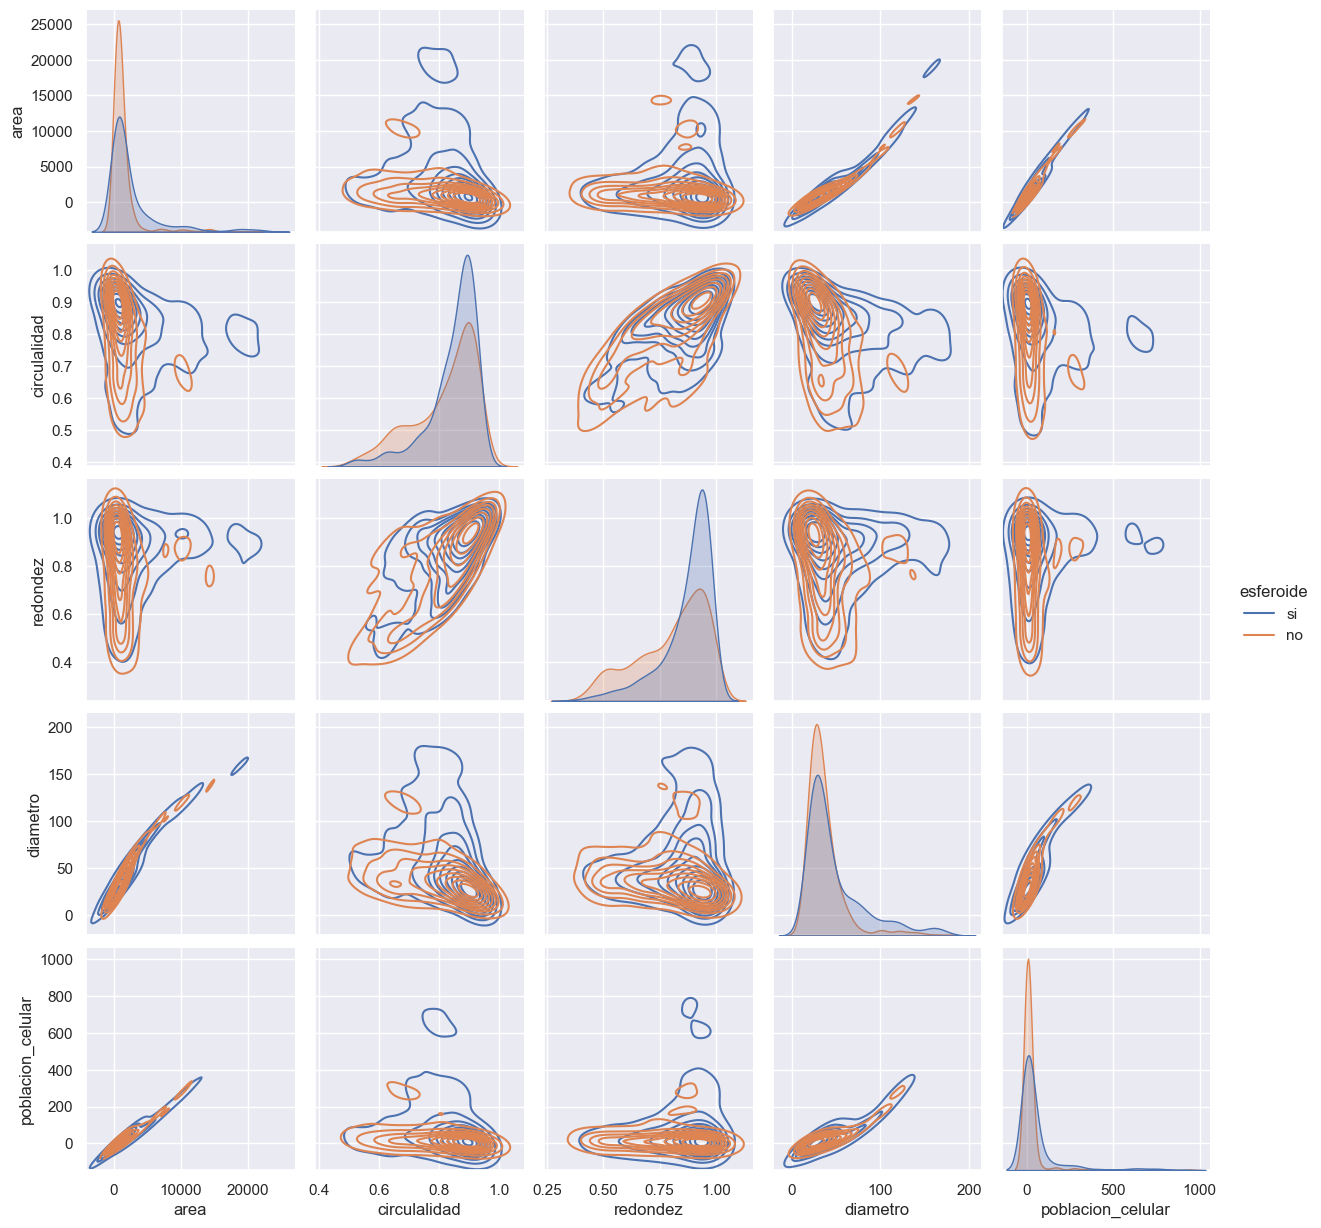

In [222]:
shape_cols = ['area',
              #'perimetro',
              #'ancho',
              #'altura',
              'circulalidad',
              #'feret',
              #'feret_x',
              #'feret_y',
              #'ang_feret',
              #'min_feret',
              #'razon_aspecto',
              'redondez',
              #'solidez',
              #'esferoide',
              #'dia',
              'diametro',
              'poblacion_celular'
             ]

sns.set_theme(style="darkgrid")

sns.pairplot(df,
            vars=shape_cols,
            hue='esferoide',
            kind='kde') # scatter
plt.show()

Empecemos analizando los histogramas (los gráficos sobre la diagonal). Todas las distribuciones parecen mostrar diferencias claras según se trate o no de esferoides. Recordemos que:
- El **sesgo** ([skewness](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html)) $\alpha_3$ de la distribución refleja la asimetría de la misma, siendo positivo cuando hay más área bajo la distribución a la derecha de la media.
- La **curtosis relativa** ([kurtosis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html)) $\alpha_{4R}$ representa cuan “picuda” o “achatada” es la distribución, y es positiva para distribuciones más picudas que la distribución normal (y negativa cuando es más achatada que esta).

Veamos variable por variable:
1. Área: los esferoides tienen menor área, lo cual tiene sentido ya que los esferoides “no” son agregados que se han unido entre sí, por lo que esperamos que tengan más área. Además, la distribución de áreas para los esferoides parece tener una curtosis mayor.
2. Circularidad: los esferoides tienen mayor circularidad, lo cual es esperable porque al no haberse “pegoteado”, pueden mantener la forma esférica original (que esperamos por simetría).

#### Área

Hagamos un histograma de las áreas, separando según sean o no esferoides. Para que se visualice mejor la parte interesante de la distribución, ponemos un corte en las áreas en 15000, e incluimos la curva de la distribución.

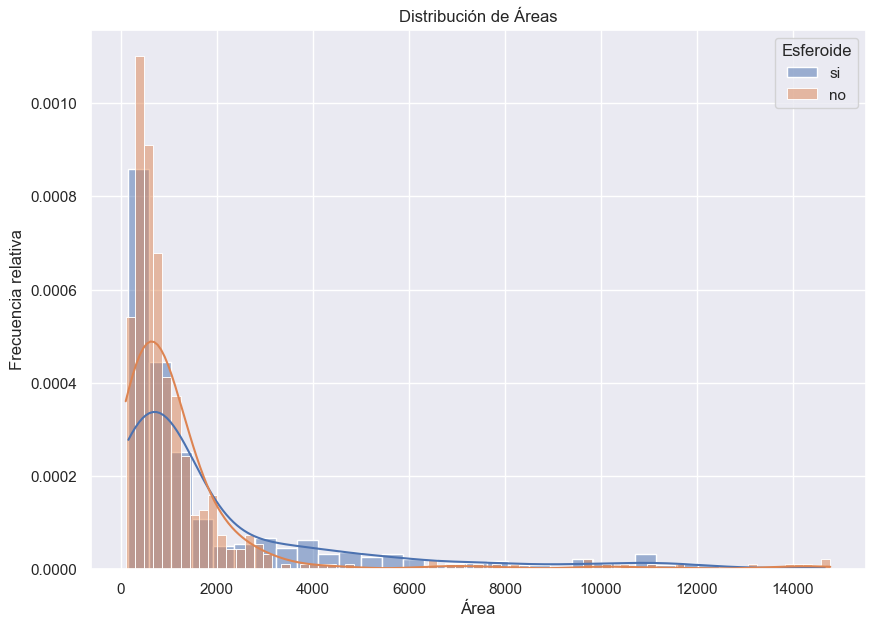

In [223]:
sns.set_theme(style="darkgrid")

si_no = df['esferoide'].unique()

df_area_limitted = df.loc[df['area']<15000]

plt.figure(figsize=(10, 7))
plt.title('Distribución de Áreas')

#print("\n")

for esferoide in si_no:
    subset = df_area_limitted[df_area_limitted['esferoide'] == esferoide]
    sns.histplot(subset['area'], kde=True, stat="density", label=esferoide)

plt.xlabel('Área')
plt.ylabel('Frecuencia relativa')
plt.legend(title='Esferoide')
plt.show()


Esferoide si:

	Mean: 2572.568
	Standard Deviation: 4076.134
	Skewness: 2.866
	Kurtosis: 8.547

Esferoide no:

	Mean: 1292.487
	Standard Deviation: 2216.867
	Skewness: 4.825
	Kurtosis: 26.53


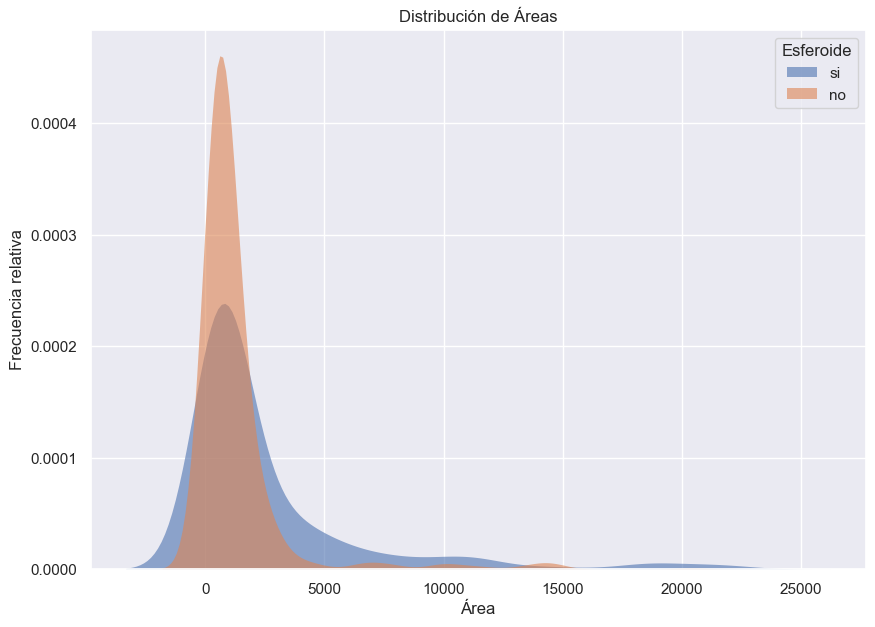

In [224]:
# Let's look more closely to the distributions and calculate their properties

sns.set_theme(style="darkgrid")

esferoides = df['esferoide'].unique()

plt.figure(figsize=(10, 7))
plt.title('Distribución de Áreas')

mean_sino = [0,0]
std_sino = [0,0]
skew_sino = [0,0]
kurt_sino =[0,0]

for i, esferoide in enumerate(esferoides):
    # we select the 'si' or 'no' value
    subset = df.loc[df['esferoide'] == esferoide]
    
    # we plot the distributions
    sns.kdeplot(data=subset, x="area", fill=True, common_norm=False, 
                palette="crest", alpha=.6, linewidth=0, label=esferoide)
    
    # Calculate mean, std, skewness and kurtosis
    mean_sino[i] = np.mean(subset['area'])
    std_sino[i] = np.std(subset['area'])
    skew_sino[i] = skew(subset['area'])
    kurt_sino[i] = kurtosis(subset['area'])
    
    # print the results
    print(f"\nEsferoide {esferoide}:\n")
    print(f"\tMean: {round(mean_sino[i],3)}")
    print(f"\tStandard Deviation: {round(std_sino[i],3)}")
    print(f"\tSkewness: {round(skew_sino[i],3)}")
    print(f"\tKurtosis: {round(kurt_sino[i],3)}")

plt.xlabel('Área')
plt.ylabel('Frecuencia relativa')
plt.legend(title='Esferoide')
plt.show()


Puede ser que los esferoides logren más área porque logran prosperar (crecer). Habría que separar por días y ver cómo cambia.

In [225]:
df['dia'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

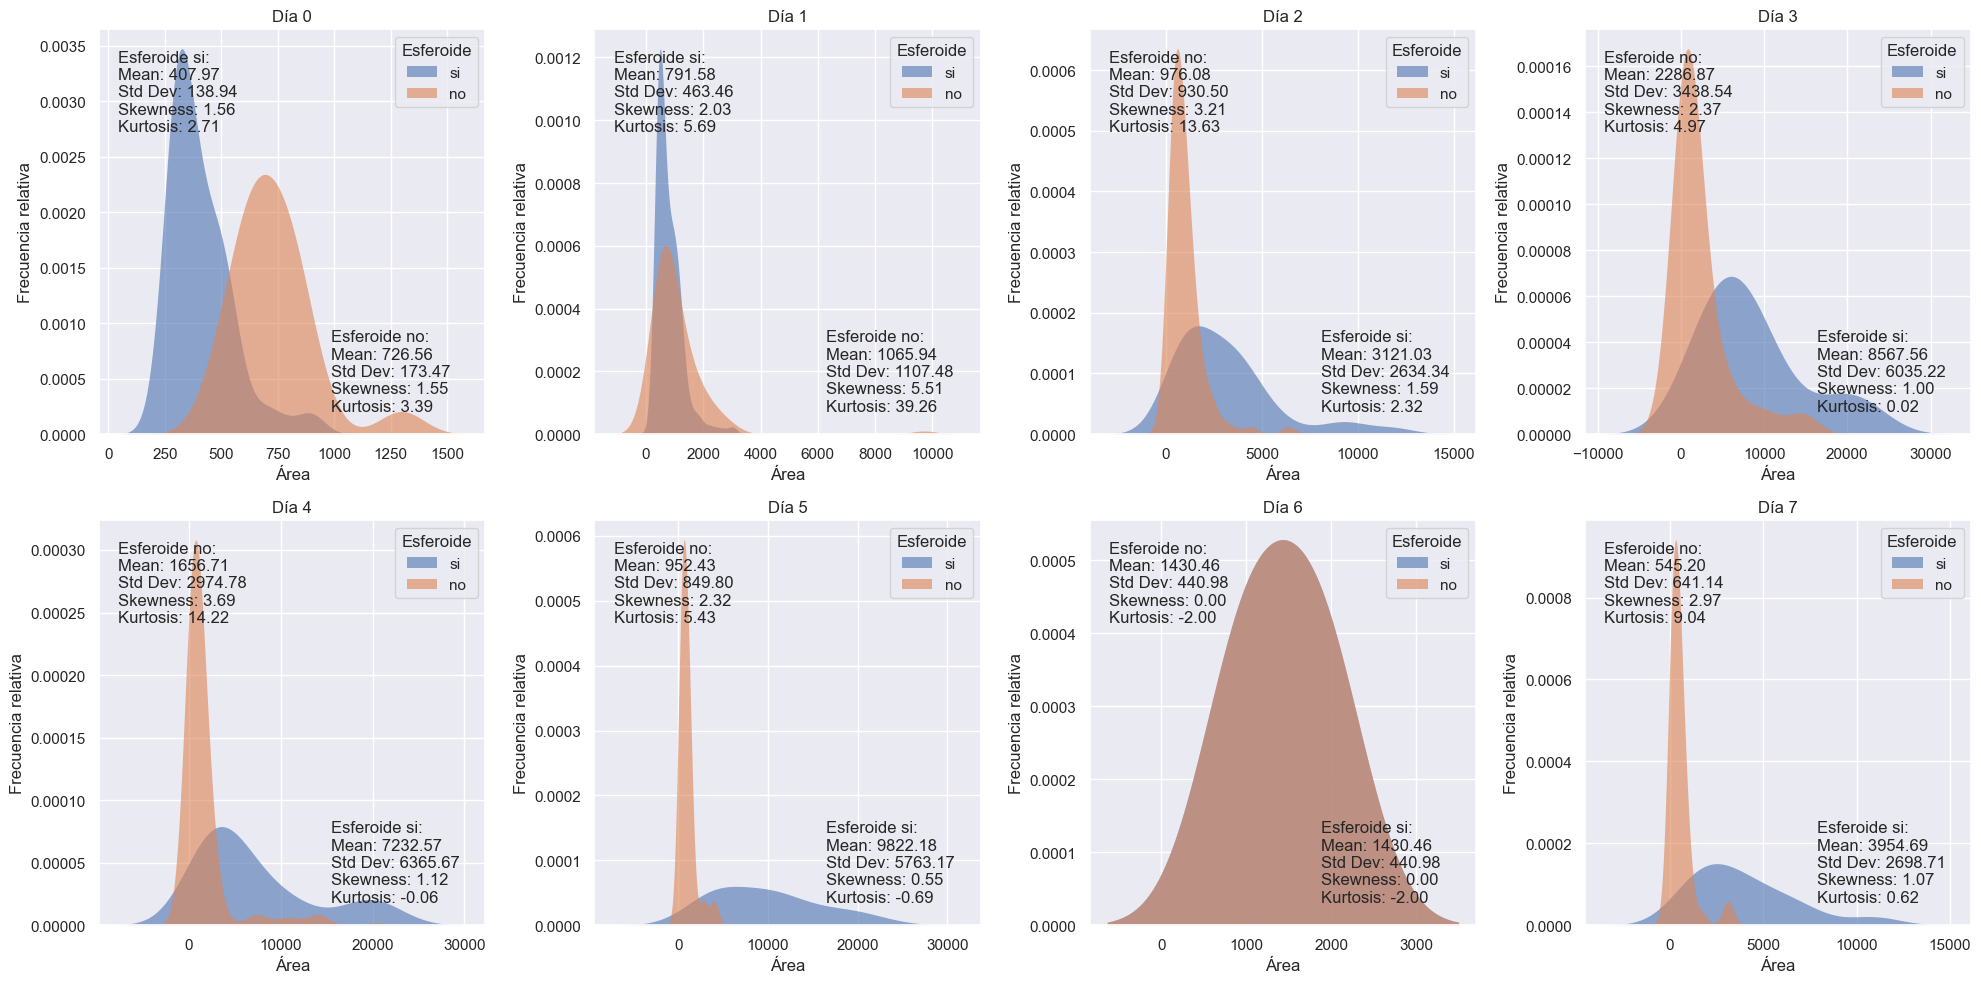

In [226]:
sns.set_theme(style="darkgrid")

esferoides = df['esferoide'].unique()
dias = df['dia'].unique()

fig, axs = plt.subplots(2, 4, figsize=(20, 10)) # Change the figsize values as needed
axs = axs.ravel()

# Upper left and lower right
text_positions = {'si': (0.6, 0.05), 'no': (0.05, 0.95)}  
vertical_alignments = {'si': 'bottom', 'no': 'top'}

# Exceptions for 'dia' values 0 and 1 (because of how distributions ended up)
text_positions_exceptions = {'si': (0.05, 0.95), 'no': (0.6, 0.05)} 
vertical_alignments_exceptions = {'si': 'top', 'no': 'bottom'}

for j, dia in enumerate(dias):
    mean_sino = [0,0]
    std_sino = [0,0]
    skew_sino = [0,0]
    kurt_sino =[0,0]
    
    for i, esferoide in enumerate(esferoides):
        # We select the 'si' or 'no' value and specific 'dia'
        subset = df.loc[(df['esferoide'] == esferoide) & (df['dia'] == dia)]
        
        # We plot the distributions
        sns.kdeplot(data=subset, x="area", fill=True, common_norm=False, 
                    palette="crest", alpha=.6, linewidth=0, label=esferoide, ax=axs[j])
        
        # Calculate mean, std, skewness and kurtosis
        mean_sino[i] = np.mean(subset['area'])
        std_sino[i] = np.std(subset['area'])
        skew_sino[i] = skew(subset['area'])
        kurt_sino[i] = kurtosis(subset['area'])
        
        # Select the positions based on 'dia'
        if dia in [0, 1]:
            text_position = text_positions_exceptions[esferoide]
            vertical_alignment = vertical_alignments_exceptions[esferoide]
        else:
            text_position = text_positions[esferoide]
            vertical_alignment = vertical_alignments[esferoide]
        
        # Annotate the results
        stats_text = f"Esferoide {esferoide}:\nMean: {mean_sino[i]:.2f}\nStd Dev: {std_sino[i]:.2f}\nSkewness: {skew_sino[i]:.2f}\nKurtosis: {kurt_sino[i]:.2f}"
        axs[j].text(text_position[0], text_position[1], stats_text, 
                    transform=axs[j].transAxes, verticalalignment=vertical_alignment)

    axs[j].set_xlabel('Área')
    axs[j].set_ylabel('Frecuencia relativa')
    axs[j].legend(title='Esferoide')
    axs[j].set_title(f'Día {dia}')

plt.tight_layout()
plt.show()


Los gráficos separados por día nos permiten describir mejor nuestro problema. Uno podría interpretar que a tiempos tempranos los esferoides son más pequeños que los no esferoides, pues estos últimos son agregados que se han unido. Pero a medida que el tiempo avanza, los esferoides logran prosperar más que los no esferoides. Esto puede verse observando las medias de las distrubuciones. Para el día 0, el área media de los esferoides es menor a la del resto. Para el día 1, este sigue siendo el caso, pero las áreas se parecen mucho más. A partir del día 2, los esferoides tienen una área media mayor al resto. Veamos este aspecto (por separado) en más detalle.

Desde ya, el día 6 va a ser un problema, porque las distribuciones se están solapando de manera perfecta y no tienen sesgo. Como mínimo debemos estar teniendo pocos datos, pero eso no explica que se solapen.

In [227]:
# Create an empty DataFrame to store the stats

stats_df = pd.DataFrame(columns=['dia', 'esferoide', 'mean', 'std', 'skewness', 'kurtosis'])

for dia in dias:
    for esferoide in esferoides:
        # Select the 'si' or 'no' value and specific 'dia'
        subset = df.loc[(df['esferoide'] == esferoide) & (df['dia'] == dia)]
        
        # Calculate mean, std, skewness and kurtosis
        mean = np.mean(subset['area'])
        std = np.std(subset['area'])
        skewness = skew(subset['area'])
        kurt = kurtosis(subset['area'])
        
        # Append the stats to the DataFrame
        stats_df = pd.concat([stats_df, pd.DataFrame([{'dia': dia, 
                                                      'esferoide': esferoide, 
                                                      'mean': mean, 
                                                      'std': std, 
                                                      'skewness': skewness, 
                                                      'kurtosis': kurt}], 
                                                     columns=['dia', 'esferoide', 'mean', 'std', 'skewness', 'kurtosis'])], 
                             ignore_index=True)

# show the stats_df DataFrame
stats_df

,dia,esferoide,mean,std,skewness,kurtosis
0,0,si,407.971664,138.939120,1.564079e+00,2.710872
1,0,no,726.560650,173.471251,1.547132e+00,3.394319
2,1,si,791.584984,463.458069,2.032979e+00,5.690728
3,1,no,1065.940546,1107.478672,5.513719e+00,39.262927
4,2,si,3121.030984,2634.336308,1.585580e+00,2.324441
5,2,no,976.084695,930.497864,3.208161e+00,13.627069
6,3,si,8567.561678,6035.224745,9.969201e-01,0.020521
7,3,no,2286.873084,3438.540778,2.369783e+00,4.965964
8,4,si,7232.569871,6365.672252,1.120143e+00,-0.063723
9,4,no,1656.705655,2974.776368,3.693902e+00,14.224545


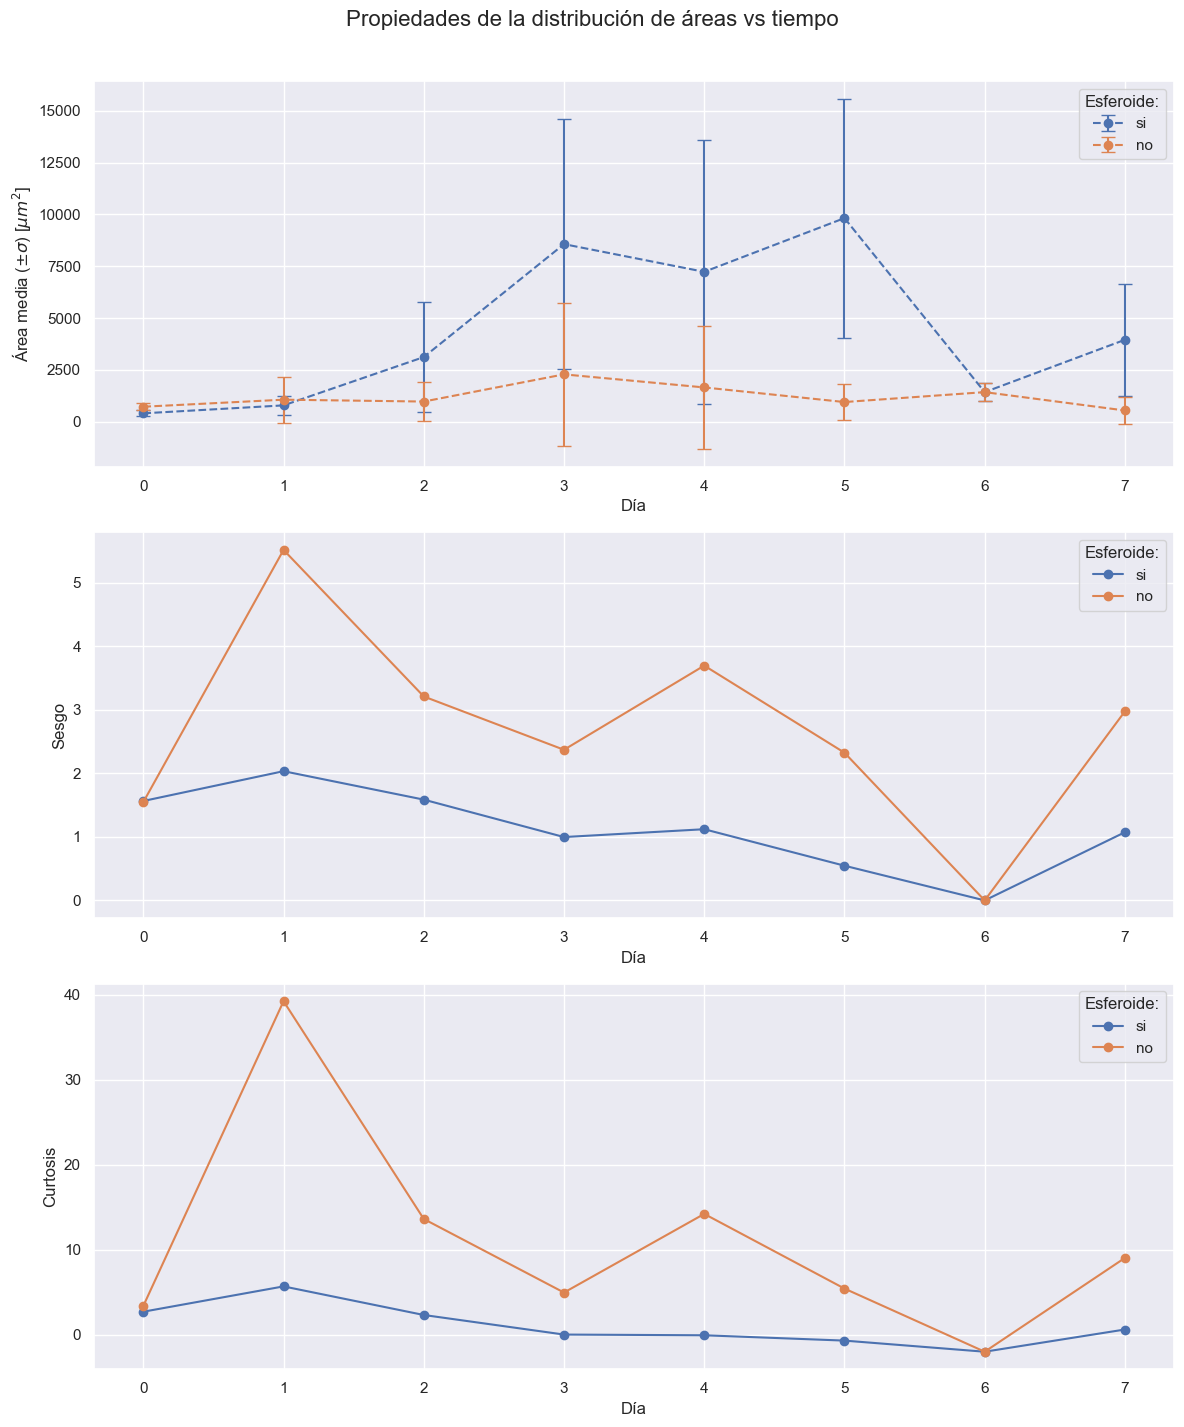

In [228]:
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# Create a list of the y variables and their corresponding labels
y_vars = [('mean', 'Área media ($\pm \sigma$) [$\mu m^2$]'), ('skewness', 'Sesgo'), ('kurtosis', 'Curtosis')]
  
for i, (y_var, y_label) in enumerate(y_vars):
    for esferoide in esferoides:
        subset = stats_df[stats_df['esferoide'] == esferoide]
        if y_var == 'mean':
            axs[i].errorbar(x=subset['dia'], y=subset[y_var], yerr=subset['std'], 
                            label=esferoide, fmt='o--', capsize=5)
        else:
            axs[i].plot(subset['dia'], subset[y_var], 'o-', label=esferoide)
        axs[i].set_ylabel(y_label)
        axs[i].set_xlabel('Día')  # Add x-label for each subplot
        axs[i].legend(title='Esferoide:')

fig.suptitle('Propiedades de la distribución de áreas vs tiempo', fontsize=16)  # Add a general title for the whole figure
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust the layout to make room for the title
plt.show()


En el gráfico anterior se corrobora que el área media de los esferoides comienza siendo menor, pero luego sobrepasa a la del resto. La única excepción es el día 6, donde el problema parece ser que la muestra de agregados que se tomó (los agregados fotografiados) tiene un conteo bajo de esferoides.

In [229]:
df.groupby(["dia","esferoide"]).size()

dia  esferoide
0    no            20
     si            74
1    no            89
     si           253
2    no            85
     si            70
3    no            25
     si            18
4    no           206
     si            48
5    no            24
     si            28
6    no             2
     si             2
7    no            45
     si            29
dtype: int64

In [230]:
esf_count_day_6 = df.loc[(df['esferoide'] == 'si') & (df['dia'] == 6)].shape[0]

print(f'Esferoides muestreados en el día 6: {esf_count_day_6}')

Esferoides muestreados en el día 6: 2


De todos modos, es raro que coincidan, veamos esto en más detalle.

In [231]:
df.loc[df['dia'] == 6]

,nombre_id,area,perimetro,ancho,altura,circulalidad,feret,ang_feret,min_feret,razon_aspecto,redondez,solidez,esferoide,dia,diametro,poblacion_celular
940,Esferas_BT474_dia_6_well_1_100X_11_blob_1,989.4849,119.0473,36.6848,37.3641,0.8774,38.2612,163.4956,34.3726,1.0725,0.9324,0.9593,si,6,36.3169,7.761717
941,Esferas_BT474_dia_6_well_1_100X_12_blob_1,1871.4371,162.8552,48.2337,48.2337,0.8867,52.4684,48.6745,47.7822,1.0654,0.9387,0.9758,si,6,50.1253,20.408095
942,Esferas_BT474_dia_6_well_1_100X_11_blob_1,989.4849,119.0473,36.6848,37.3641,0.8774,38.2612,163.4956,34.3726,1.0725,0.9324,0.9593,no,6,36.3169,7.761717
943,Esferas_BT474_dia_6_well_1_100X_12_blob_1,1871.4371,162.8552,48.2337,48.2337,0.8867,52.4684,48.6745,47.7822,1.0654,0.9387,0.9758,no,6,50.1253,20.408095


Notemos que los datos del día 6 coinciden porque los mismos 2 agregados están incluidos como esferoides “si” y “no”. Esto es lo que ocasionaba que las distribuciones se solapen y es, sin duda, un error en el data set. “`Esferas_BT474_dia_6_well_1_100X_11_blob_1`” es o no es un esferoide, y lo mismo para el “`Esferas_BT474_dia_6_well_1_100X_12_blob_1`”. En cualquier caso, aun pudiendo averiguar cómo es y corregirlo, tendríamos una categoría sin datos o tendríamos un dato por categoría, por lo que no nos va a quedar otra que desestimar los datos para el día 6.

Resumen:
- El área para los esferoides comienza siendo menor, pero eventualmente supera a la del resto.
- Si bien ambos grupos tienen sesgo positivo (las distribuciones son asimétricas, con más área a la derecha de la media), los esferoides tienen un sesgo menor al resto, que parece disminuir con el tiempo.
- En general, la curtosis de las distribuciones de área para los esferoides es menor a la del resto y cae con el tiempo, indicando que las distribuciones de áreas son más “achatadas” para los esferoides que para el resto.
- Los datos del día 6 son problemáticos

Algo llamativo, es que durante los primeros 5 días, el área de los esferoides parece tender a aumentar (algo que esperamos si estos están creciendo), pero este trend se corta en los últimos dos días. Si bien podemos desestimar los datos del día 6, los del día 7 no son pocos.

In [232]:
esf_count_day_7 = df.loc[(df['esferoide'] == 'si') & (df['dia'] == 7)].shape[0]

print(f'Esferoides muestreados en el día 7: {esf_count_day_7}')

Esferoides muestreados en el día 7: 29


#### Correlación entre las variables

En vez de repetir todo este análisis para las otras 3 variables, podría tratar de elegir algún par de “representantes”: variables que estén poco correlacionadas entre sí, pero muy correlacionadas con el resto, para hacer un plot de densidad en 2D y tratar de identificar grupos.

Dado que desconocemos la distribución de las variables a analizar, calcularemos la correlación empleando el coeficiente de Kendall.

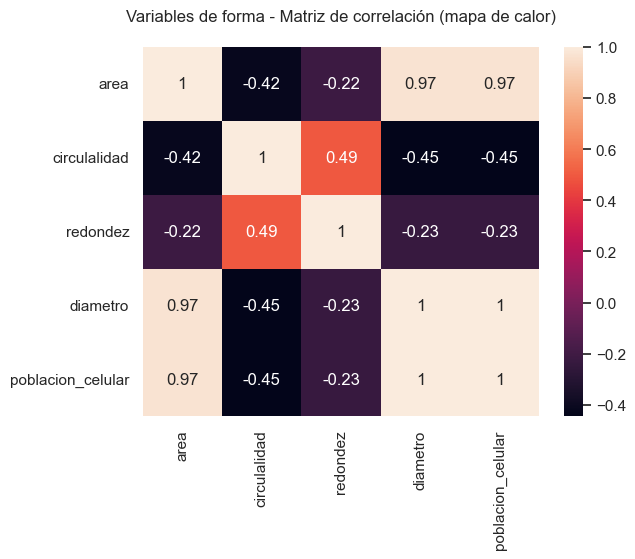

In [233]:
df_corr = df[shape_cols].dropna().corr(method='kendall')
sns.heatmap(df_corr, annot=True)
plt.title('Variables de forma - Matriz de correlación (mapa de calor)\n')
plt.show()

Estas cuatro variables se pueden dividir en dos grupos:
- Indicadoras de tamaño: área y diámetro
- Indicadoras de esfericidad: circularidad y redondez

De tamaño nos quedamos con área, ya que es la más independiente a las del otro grupo (por la definición de diámetro y los valores de correlación del gráfico anterior). 

#### Redondez y Circularidad

De esfericidad y redondez, quedarnos con una sola variable puede que no sea demasiado robusto, pero aprovechando que ambas variables pertenecen al $[0,1]$, valiendo 1 para un círculo, podemos crear una variable combinada

$$round\_circ = \alpha_1 circularidad + \alpha_2 redondez$$

donde $\alpha_1+\alpha_2=1$ y $\alpha_i>\alpha_j$ indica que se le da más peso al criterio $i$ que al $j$. De este modo, para que una figura tenga $round\_circ = 1$, debe tener ambas métricas iguales a 1. Como en principio no tenemos argumentos para justificar una asimetría, tomamos $\alpha_1=\alpha_2$ y obtenemos $$round\_circ = \frac{circularidad + redondez}{2}$$ 

Siguiendo esta línea, aplicaremos PCA, para reducir las dos columnas mencionadas, a una sola que tenga en cuenta las dos variables. Dado que ambas columnas toman valores entre 0 y 1, no es necesario realizar ninguna técnica de estandarización de los datos.

Calculemos esta nueva columna y hagamos el mismo análisis que para el área.

Graficamos la función acumulativa de la varianza en función de las dimensiones (columnas) de nuestras columnas seleccionadas, para poder decidir la dimensión a la cual llevaremos el df con PCA que expliquen el 90% de nuestra varianza. De acuerdo al gráfico que se muestra a continuación, n=1. 

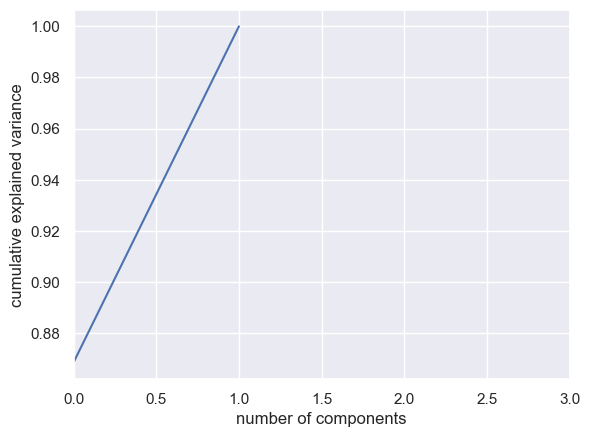

In [234]:
from sklearn.decomposition import PCA

# Filtramos el df para quedarnos con las columnas redondez y circulalidad
filtered_df = df[['redondez', 'circulalidad']].copy()

# Aplicamos PCA
pca = PCA().fit(filtered_df)

# Graficamos explained_variance_ratio_
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim(0, 3)

# Show the plot
plt.show()



In [235]:
#Aplicamos PCA para reducir la dimensionalidad del df.
pca = PCA(n_components= 1)
df_PCA = pca.fit_transform(filtered_df)

# convertimos los resultados en un dataframe de pandas.
df_PCA = pd.DataFrame(df_PCA)

# Verificamos el tamaño de nuestro df
df_PCA.shape


(1018, 1)

In [236]:
#Renombramos la columna
df_PCA = df_PCA.rename(columns={0: 'redondez_circ'})

# Crear un nuevo DataFrame sin las columnas "circularidad" y "redondez"
df_redondez_circ = pd.concat([df.drop(['redondez', 'circulalidad'], axis=1), df_PCA], axis=1)

# Verificar el nuevo DataFrame
df_redondez_circ.head()

,nombre_id,area,perimetro,ancho,altura,feret,ang_feret,min_feret,razon_aspecto,solidez,esferoide,dia,diametro,poblacion_celular,redondez_circ
0,Esferas_BT474_dia_0_well_1_100X_1_blob_1,324.4440,67.3603,21.0598,19.7011,22.2117,23.4287,19.7011,1.0653,0.9500,si,0,20.95640,1.491357,-0.121596
1,Esferas_BT474_dia_0_well_1_100X_1_blob_2,497.5115,82.8004,25.8152,25.1359,26.8751,16.1443,25.1289,1.0475,0.9569,si,0,26.00200,2.848733,-0.142143
2,Esferas_BT474_dia_0_well_1_100X_1_blob_3,282.9078,62.1586,19.7011,18.3424,20.4370,15.4222,18.3424,1.0395,0.9519,si,0,19.38970,1.181258,-0.152725
3,Esferas_BT474_dia_0_well_1_100X_1_blob_5,500.7421,84.5571,26.4946,25.1359,26.6336,174.1440,25.1359,1.0278,0.9493,si,0,25.88475,2.810370,-0.141354
4,Esferas_BT474_dia_0_well_1_100X_1_blob_6,492.8964,82.0728,25.1359,24.4565,26.2232,143.4270,24.4565,1.0186,0.9643,si,0,25.33985,2.636596,-0.169249


El inconveniente que nos encontramos aquí, es que si bien pudimos generar una combinación de nuestras columnas, la nueva columna redondez_circ tiene valores no que no están directamente relacionados con las columnas anteriores y son difíciles de interpretar. Por lo que decidimos por el momento continuar trabajando con el df original.

A continuación, veremos la distribucion de ambas columnas y evaluaremos nuevamente la correlación con un scatterplot.

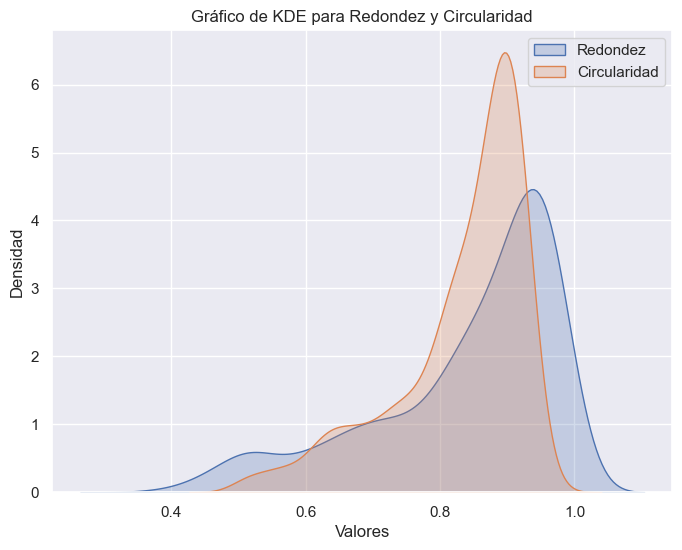

In [237]:
# Crear el gráfico combinado de KDE para redondez y circularidad
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df['redondez'], label='Redondez',fill=True)
sns.kdeplot(data=df['circulalidad'], label='Circularidad',fill=True)
plt.xlabel('Valores')
plt.ylabel('Densidad')
plt.title('Gráfico de KDE para Redondez y Circularidad')
plt.legend()
plt.show()

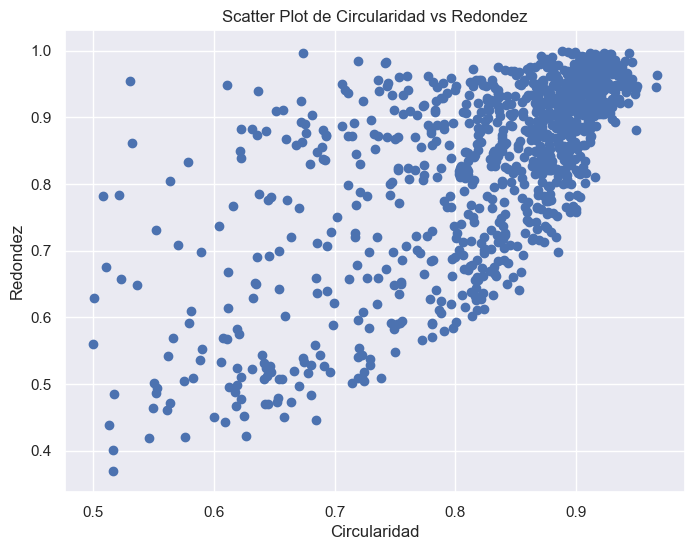

In [238]:
# Creamos scatter plot de circularidad y redondez
plt.figure(figsize=(8, 6))
plt.scatter(df['circulalidad'], df['redondez'])
plt.xlabel('Circularidad')
plt.ylabel('Redondez')
plt.title('Scatter Plot de Circularidad vs Redondez')
plt.show()

Si bien las distribuciones de ambas variables son similares, el heatmap y el scatter plot nos muestran que las variables no están tan correlacionadas entre sí y quizás sería precipitado eliminar una de las dos columnas. Continuaremos analizando ambas columnas.

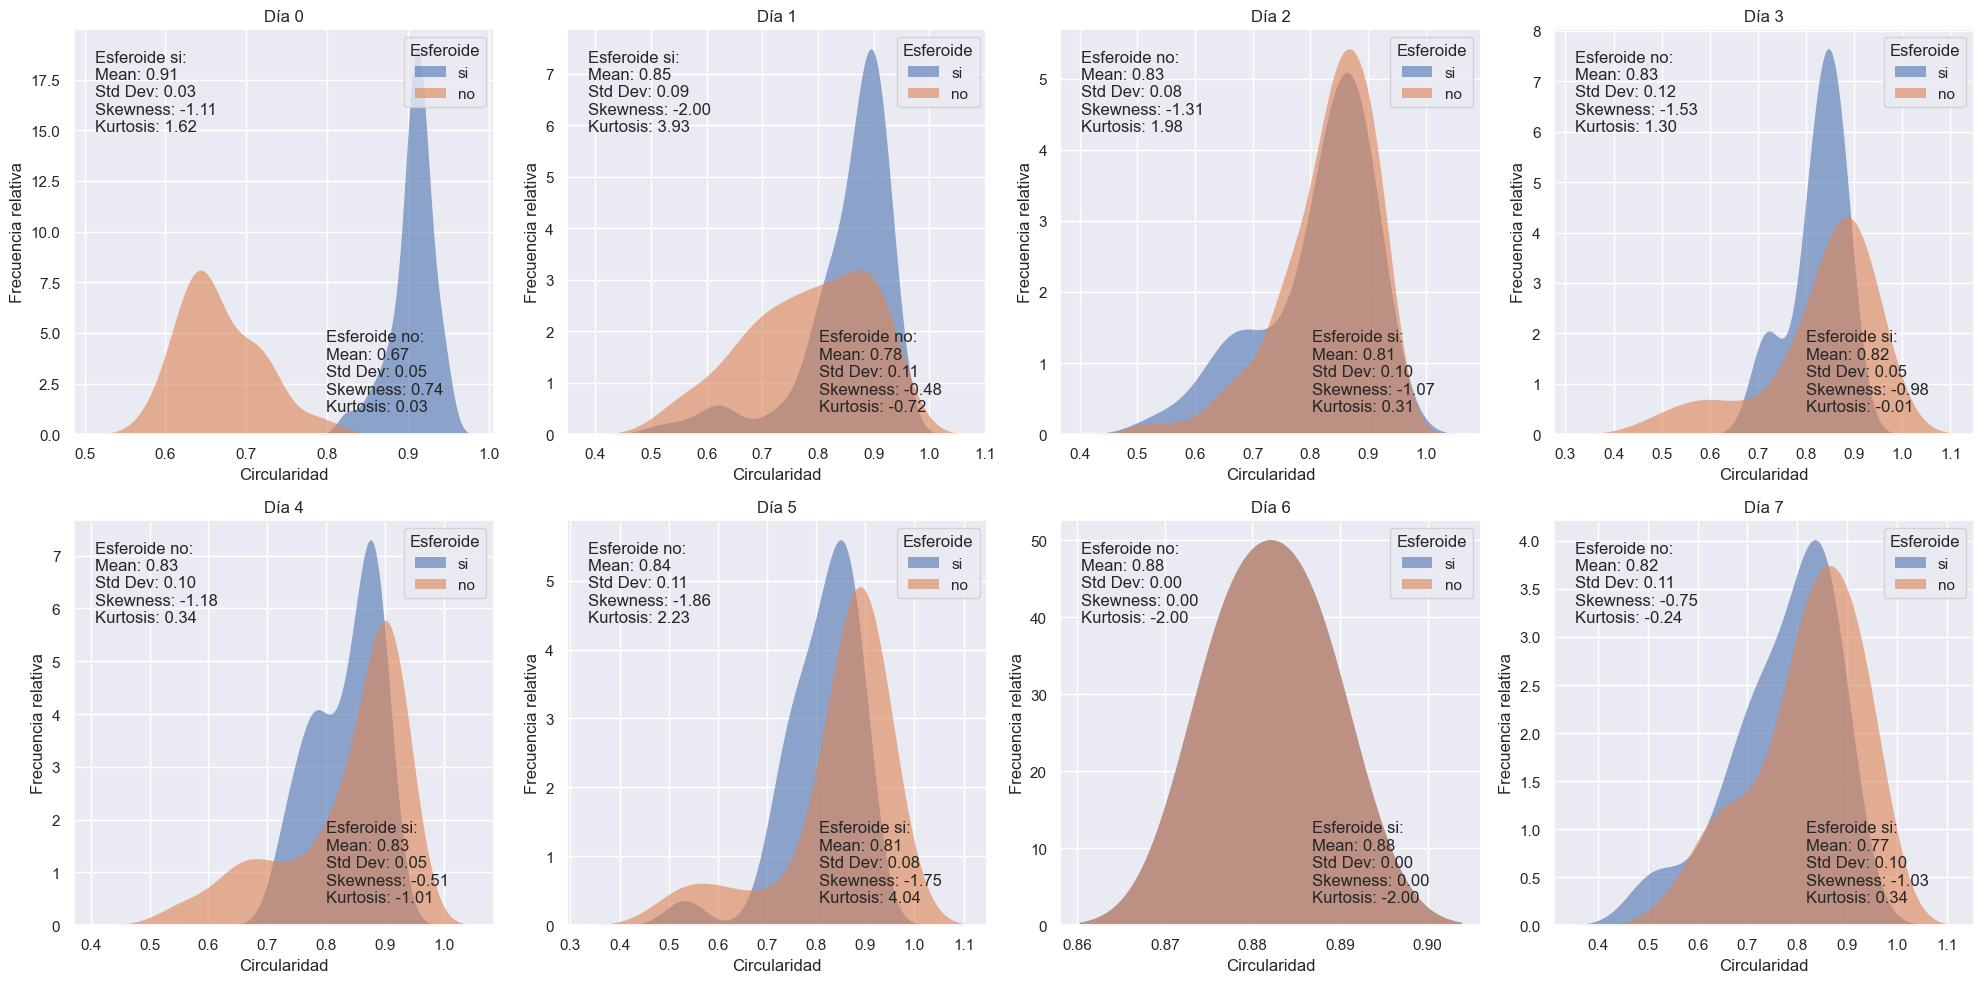

In [239]:
esferoides = df['esferoide'].unique()
dias = df['dia'].unique()

fig, axs = plt.subplots(2, 4, figsize=(20,10)) # Change the figsize values as needed
axs = axs.ravel()

# Upper left and lower right
text_positions = {'si': (0.6, 0.05), 'no': (0.05, 0.95)}  
vertical_alignments = {'si': 'bottom', 'no': 'top'}

# Exceptions for 'dia' values 0 and 1 (because of how distributions ended up)
text_positions_exceptions = {'si': (0.05, 0.95), 'no': (0.6, 0.05)} 
vertical_alignments_exceptions = {'si': 'top', 'no': 'bottom'}

for j, dia in enumerate(dias):
    mean_sino = [0,0]
    std_sino = [0,0]
    skew_sino = [0,0]
    kurt_sino =[0,0]
    
    for i, esferoide in enumerate(esferoides):
        # We select the 'si' or 'no' value and specific 'dia'
        subset = df.loc[(df['esferoide'] == esferoide) & (df['dia'] == dia)]
        
        # We plot the distributions
        sns.kdeplot(data=subset, x="circulalidad", fill=True, common_norm=False, 
                    palette="crest", alpha=.6, linewidth=0, label=esferoide, ax=axs[j])
        
        # Calculate mean, std, skewness and kurtosis
        mean_sino[i] = np.mean(subset['circulalidad'])
        std_sino[i] = np.std(subset['circulalidad'])
        skew_sino[i] = skew(subset['circulalidad'])
        kurt_sino[i] = kurtosis(subset['circulalidad'])
        
        # Select the positions based on 'dia'
        if dia in [0, 1]:
            text_position = text_positions_exceptions[esferoide]
            vertical_alignment = vertical_alignments_exceptions[esferoide]
        else:
            text_position = text_positions[esferoide]
            vertical_alignment = vertical_alignments[esferoide]
        
        # Annotate the results
        stats_text = f"Esferoide {esferoide}:\nMean: {mean_sino[i]:.2f}\nStd Dev: {std_sino[i]:.2f}\nSkewness: {skew_sino[i]:.2f}\nKurtosis: {kurt_sino[i]:.2f}"
        axs[j].text(text_position[0], text_position[1], stats_text, 
                    transform=axs[j].transAxes, verticalalignment=vertical_alignment)

    axs[j].set_xlabel('Circularidad')
    axs[j].set_ylabel('Frecuencia relativa')
    axs[j].legend(title='Esferoide')
    axs[j].set_title(f'Día {dia}')

plt.tight_layout()
plt.show()


In [240]:
# Create an empty DataFrame to store the stats

stats_circulalidad_df = pd.DataFrame(columns=['dia', 'esferoide', 'mean', 'std', 'skewness', 'kurtosis'])

for dia in dias:
    for esferoide in esferoides:
        # Select the 'si' or 'no' value and specific 'dia'
        subset = df.loc[(df['esferoide'] == esferoide) & (df['dia'] == dia)]
        
        # Calculate mean, std, skewness and kurtosis
        mean = np.mean(subset['circulalidad'])
        std = np.std(subset['circulalidad'])
        skewness = skew(subset['circulalidad'])
        kurt = kurtosis(subset['circulalidad'])
        
        # Append the stats to the DataFrame
        stats_circulalidad_df = pd.concat([stats_circulalidad_df, pd.DataFrame([{'dia': dia, 
                                                      'esferoide': esferoide, 
                                                      'mean': mean, 
                                                      'std': std, 
                                                      'skewness': skewness, 
                                                      'kurtosis': kurt}], 
                                                     columns=['dia', 'esferoide', 'mean', 'std', 'skewness', 'kurtosis'])], 
                             ignore_index=True)

# show the stats_df DataFrame
stats_circulalidad_df

,dia,esferoide,mean,std,skewness,kurtosis
0,0,si,0.905868,0.025734,-1.112583,1.615807
1,0,no,0.667160,0.047561,0.739093,0.025398
2,1,si,0.851075,0.085464,-1.995127,3.925793
3,1,no,0.782126,0.109494,-0.478929,-0.720437
4,2,si,0.811083,0.095761,-1.070524,0.313246
5,2,no,0.830693,0.081687,-1.312935,1.976404
6,3,si,0.823978,0.053989,-0.976221,-0.011816
7,3,no,0.827576,0.115037,-1.531960,1.303921
8,4,si,0.833673,0.054958,-0.512661,-1.010103
9,4,no,0.831317,0.104282,-1.183882,0.335409


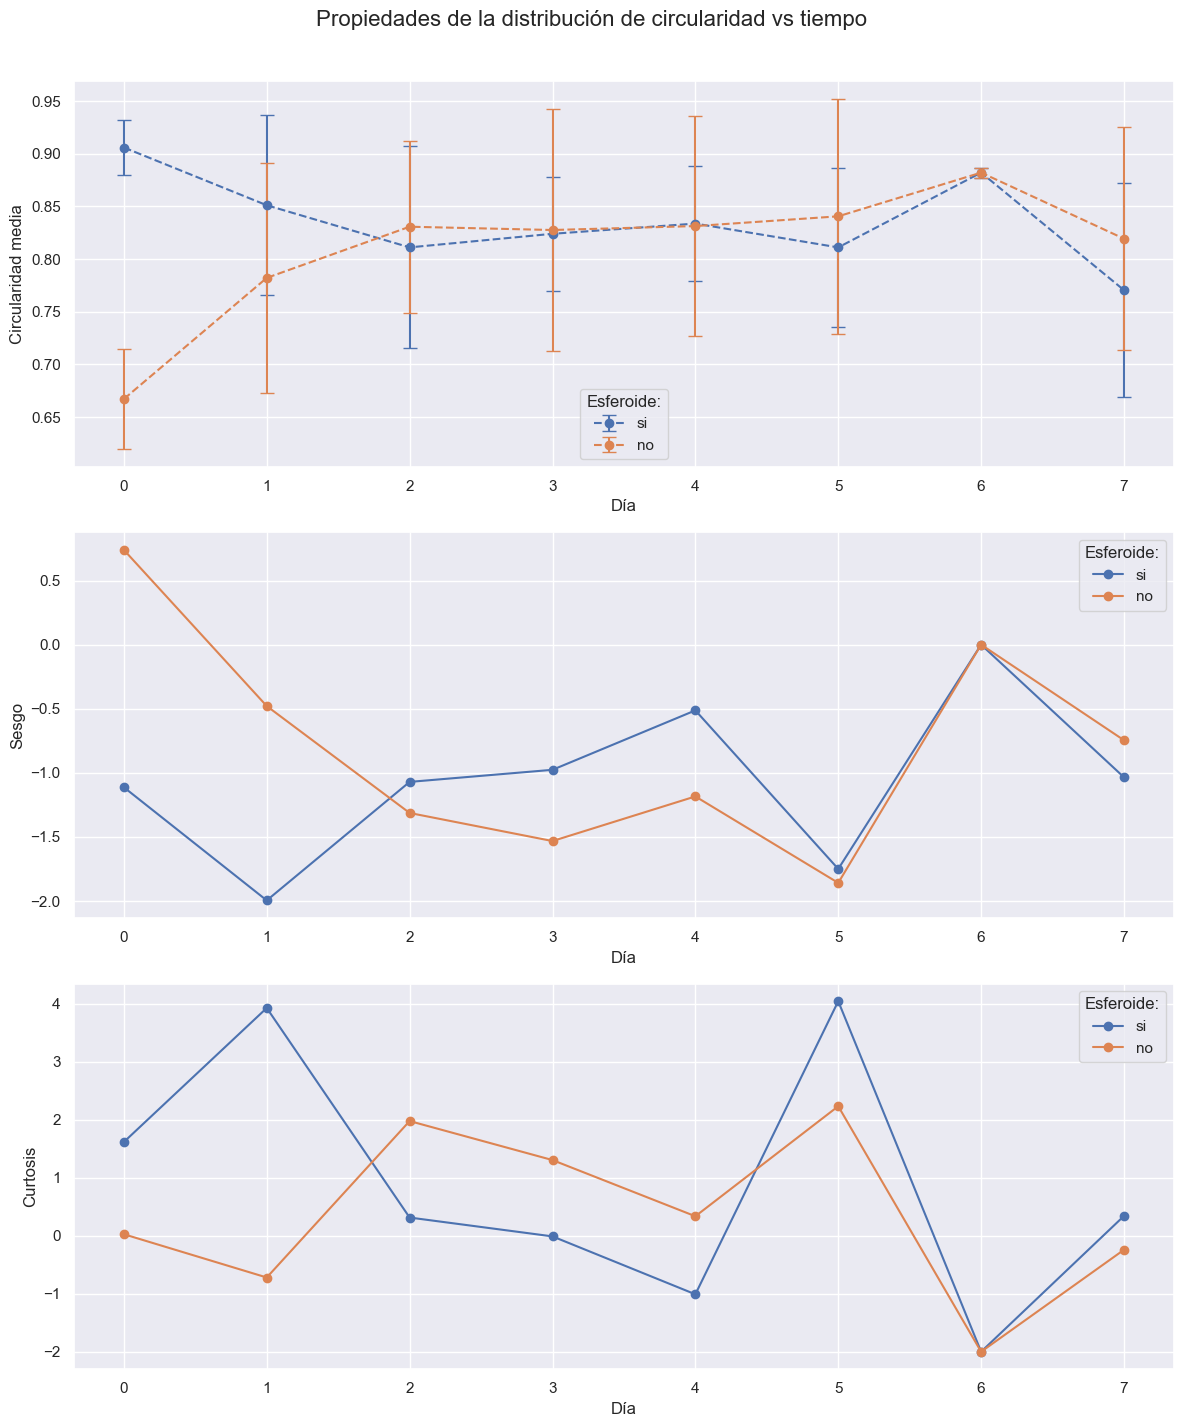

In [241]:
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# Create a list of the y variables and their corresponding labels
y_vars = [('mean', 'Circularidad media'), ('skewness', 'Sesgo'), ('kurtosis', 'Curtosis')]
  
for i, (y_var, y_label) in enumerate(y_vars):
    for esferoide in esferoides:
        subset = stats_circulalidad_df[stats_circulalidad_df['esferoide'] == esferoide]
        if y_var == 'mean':
            axs[i].errorbar(x=subset['dia'], y=subset[y_var], yerr=subset['std'], 
                            label=esferoide, fmt='o--', capsize=5)
        else:
            axs[i].plot(subset['dia'], subset[y_var], 'o-', label=esferoide)
        axs[i].set_ylabel(y_label)
        axs[i].set_xlabel('Día')  # Add x-label for each subplot
        axs[i].legend(title='Esferoide:')

fig.suptitle('Propiedades de la distribución de circularidad vs tiempo', fontsize=16)  # Add a general title for the whole figure
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust the layout to make room for the title
plt.show()

De los graficos anteriores podemos concluir que la variable circularidad influye de manera contundente en la separación de esferoides. Del gráfico de kde, podemos ver que para algunos de los días analizados las variables se solapan y no me permitirán diferenciar esferoides.

Los gráficos de media, sesgo y curtosis se solapan en varios puntos por lo que corroboran que no se podrá diferenciar entre esferoides con esta variable.

Realicemos el mismo análisis para el caso de la varible redondez.

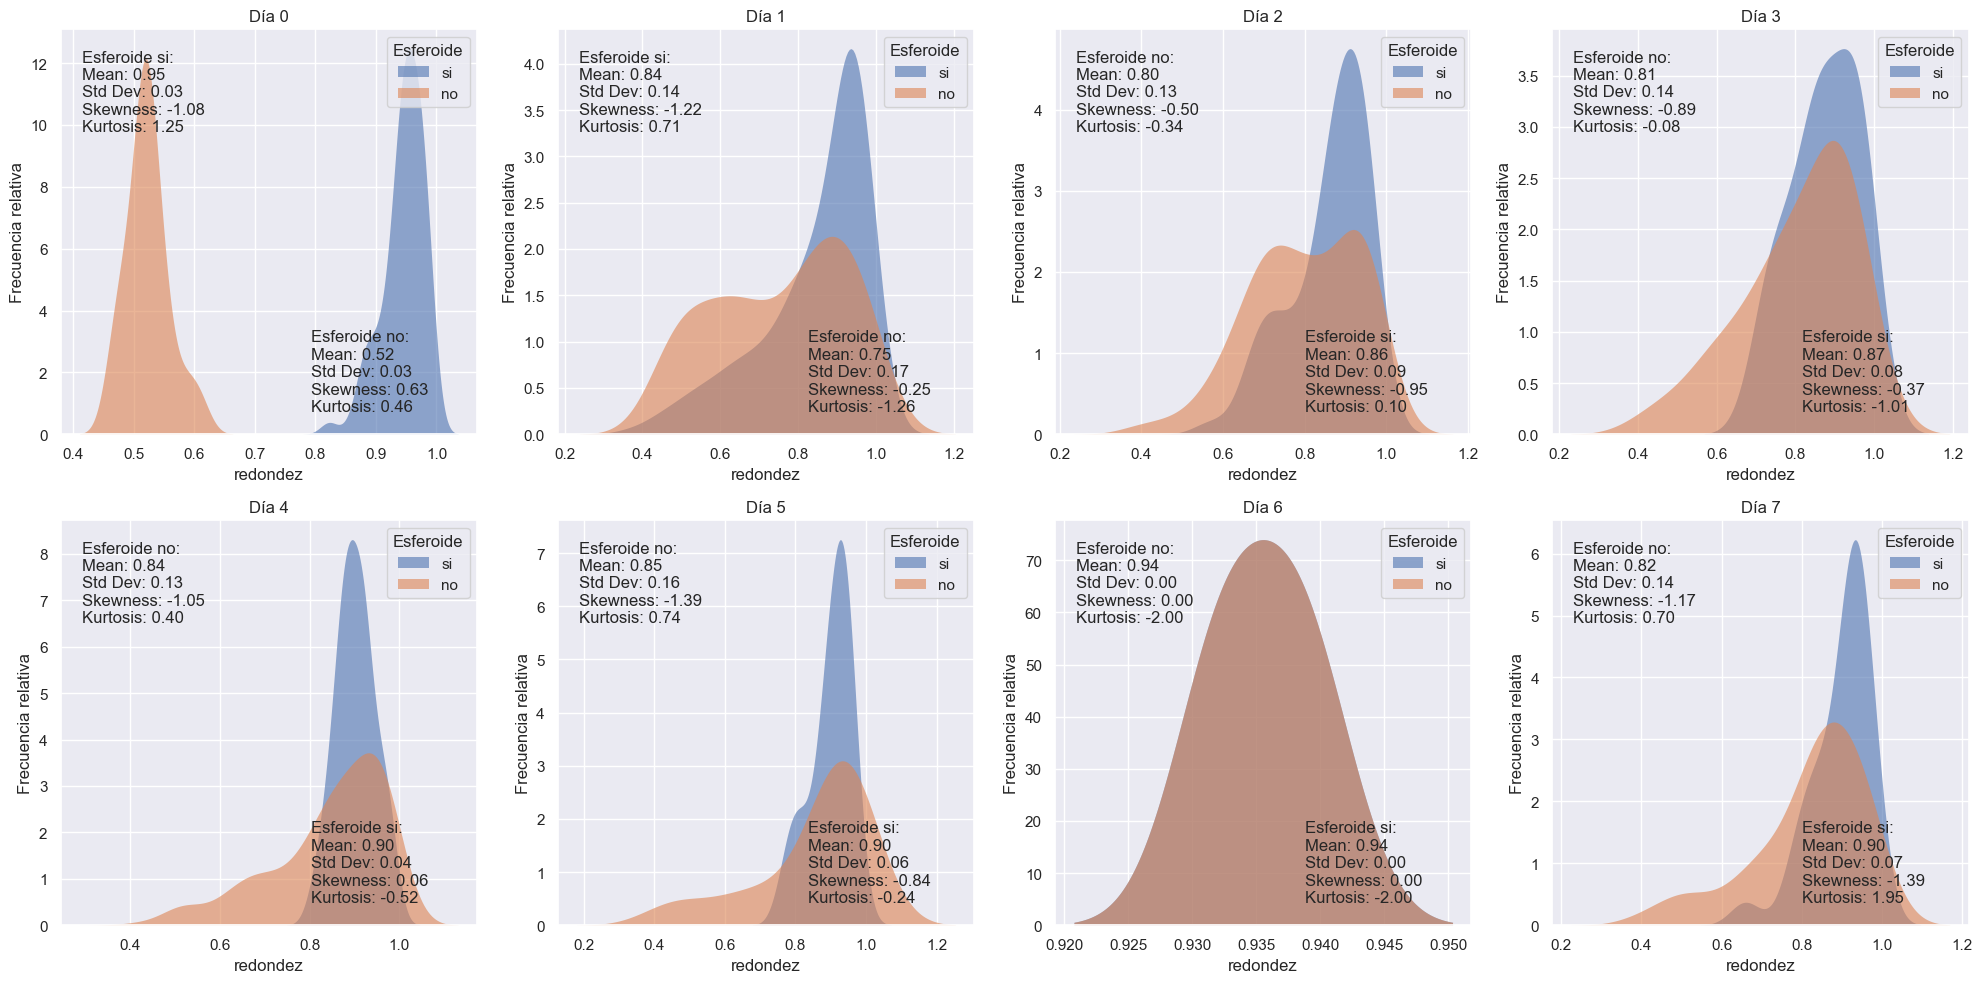

In [242]:
esferoides = df['esferoide'].unique()
dias = df['dia'].unique()

fig, axs = plt.subplots(2, 4, figsize=(20,10)) # Change the figsize values as needed
axs = axs.ravel()

# Upper left and lower right
text_positions = {'si': (0.6, 0.05), 'no': (0.05, 0.95)}  
vertical_alignments = {'si': 'bottom', 'no': 'top'}

# Exceptions for 'dia' values 0 and 1 (because of how distributions ended up)
text_positions_exceptions = {'si': (0.05, 0.95), 'no': (0.6, 0.05)} 
vertical_alignments_exceptions = {'si': 'top', 'no': 'bottom'}

for j, dia in enumerate(dias):
    mean_sino = [0,0]
    std_sino = [0,0]
    skew_sino = [0,0]
    kurt_sino =[0,0]
    
    for i, esferoide in enumerate(esferoides):
        # We select the 'si' or 'no' value and specific 'dia'
        subset = df.loc[(df['esferoide'] == esferoide) & (df['dia'] == dia)]
        
        # We plot the distributions
        sns.kdeplot(data=subset, x="redondez", fill=True, common_norm=False, 
                    palette="crest", alpha=.6, linewidth=0, label=esferoide, ax=axs[j])
        
        # Calculate mean, std, skewness and kurtosis
        mean_sino[i] = np.mean(subset['redondez'])
        std_sino[i] = np.std(subset['redondez'])
        skew_sino[i] = skew(subset['redondez'])
        kurt_sino[i] = kurtosis(subset['redondez'])
        
        # Select the positions based on 'dia'
        if dia in [0, 1]:
            text_position = text_positions_exceptions[esferoide]
            vertical_alignment = vertical_alignments_exceptions[esferoide]
        else:
            text_position = text_positions[esferoide]
            vertical_alignment = vertical_alignments[esferoide]
        
        # Annotate the results
        stats_text = f"Esferoide {esferoide}:\nMean: {mean_sino[i]:.2f}\nStd Dev: {std_sino[i]:.2f}\nSkewness: {skew_sino[i]:.2f}\nKurtosis: {kurt_sino[i]:.2f}"
        axs[j].text(text_position[0], text_position[1], stats_text, 
                    transform=axs[j].transAxes, verticalalignment=vertical_alignment)

    axs[j].set_xlabel('redondez')
    axs[j].set_ylabel('Frecuencia relativa')
    axs[j].legend(title='Esferoide')
    axs[j].set_title(f'Día {dia}')

plt.tight_layout()
plt.show()


In [243]:
# Create an empty DataFrame to store the stats

stats_redondez_df = pd.DataFrame(columns=['dia', 'esferoide', 'mean', 'std', 'skewness', 'kurtosis'])

for dia in dias:
    for esferoide in esferoides:
        # Select the 'si' or 'no' value and specific 'dia'
        subset = df.loc[(df['esferoide'] == esferoide) & (df['dia'] == dia)]
        
        # Calculate mean, std, skewness and kurtosis
        mean = np.mean(subset['redondez'])
        std = np.std(subset['redondez'])
        skewness = skew(subset['redondez'])
        kurt = kurtosis(subset['redondez'])
        
        # Append the stats to the DataFrame
        stats_redondez_df = pd.concat([stats_redondez_df, pd.DataFrame([{'dia': dia, 
                                                      'esferoide': esferoide, 
                                                      'mean': mean, 
                                                      'std': std, 
                                                      'skewness': skewness, 
                                                      'kurtosis': kurt}], 
                                                     columns=['dia', 'esferoide', 'mean', 'std', 'skewness', 'kurtosis'])], 
                             ignore_index=True)

# show the stats_df DataFrame
stats_redondez_df

,dia,esferoide,mean,std,skewness,kurtosis
0,0,si,0.945097,0.033771,-1.084146,1.245168
1,0,no,0.522425,0.033450,0.630665,0.462634
2,1,si,0.843172,0.138522,-1.215909,0.710011
3,1,no,0.750493,0.168367,-0.254934,-1.258939
4,2,si,0.857879,0.094311,-0.949300,0.095842
5,2,no,0.797320,0.133920,-0.499657,-0.344286
6,3,si,0.873817,0.083836,-0.369077,-1.012132
7,3,no,0.805676,0.137059,-0.894254,-0.077316
8,4,si,0.902008,0.042582,0.056542,-0.515801
9,4,no,0.842218,0.128582,-1.052618,0.404788


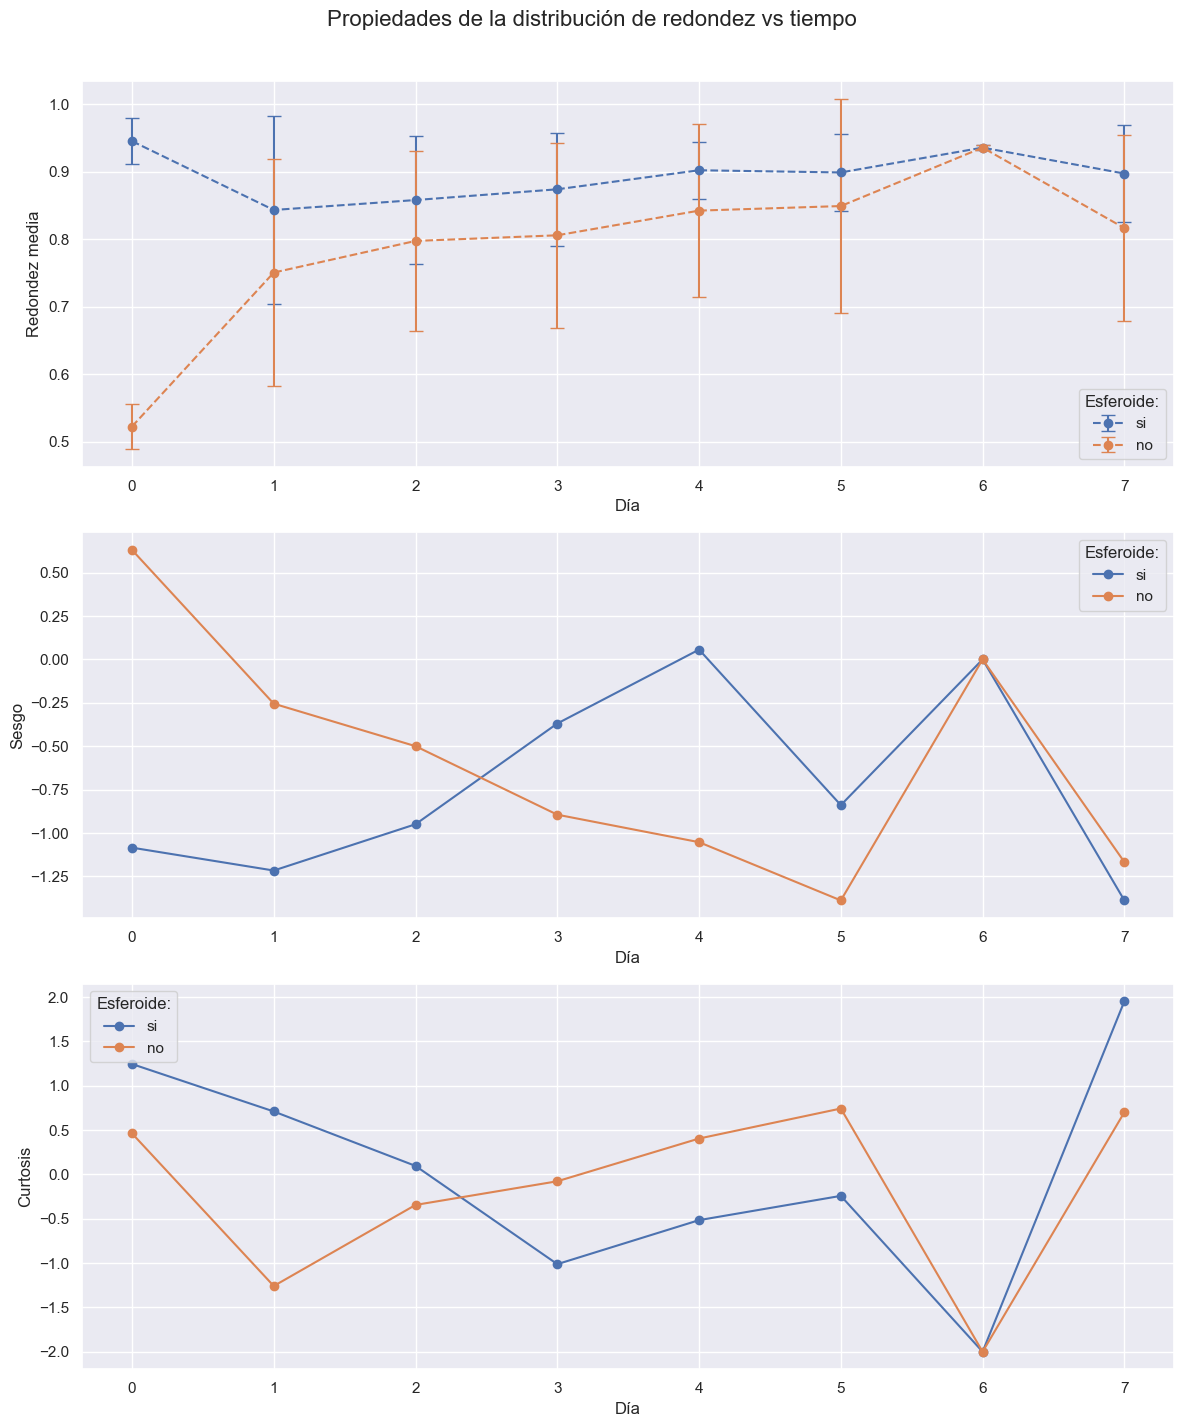

In [244]:
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# Create a list of the y variables and their corresponding labels
y_vars = [('mean', 'Redondez media'), ('skewness', 'Sesgo'), ('kurtosis', 'Curtosis')]
  
for i, (y_var, y_label) in enumerate(y_vars):
    for esferoide in esferoides:
        subset = stats_redondez_df[stats_redondez_df['esferoide'] == esferoide]
        if y_var == 'mean':
            axs[i].errorbar(x=subset['dia'], y=subset[y_var], yerr=subset['std'], 
                            label=esferoide, fmt='o--', capsize=5)
        else:
            axs[i].plot(subset['dia'], subset[y_var], 'o-', label=esferoide)
        axs[i].set_ylabel(y_label)
        axs[i].set_xlabel('Día')  # Add x-label for each subplot
        axs[i].legend(title='Esferoide:')

fig.suptitle('Propiedades de la distribución de redondez vs tiempo', fontsize=16)  # Add a general title for the whole figure
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust the layout to make room for the title
plt.show()

La variable redondez muestra resultados algo más prometedores para la separación de esferoidez que circularidad, principalmente relacionados con la curtosis. No obstante, el área es una variable mucho más apropiada para la separación de esferoides.

#### Población celular

Veamos si esta variable nos permite clasificar esferoides.

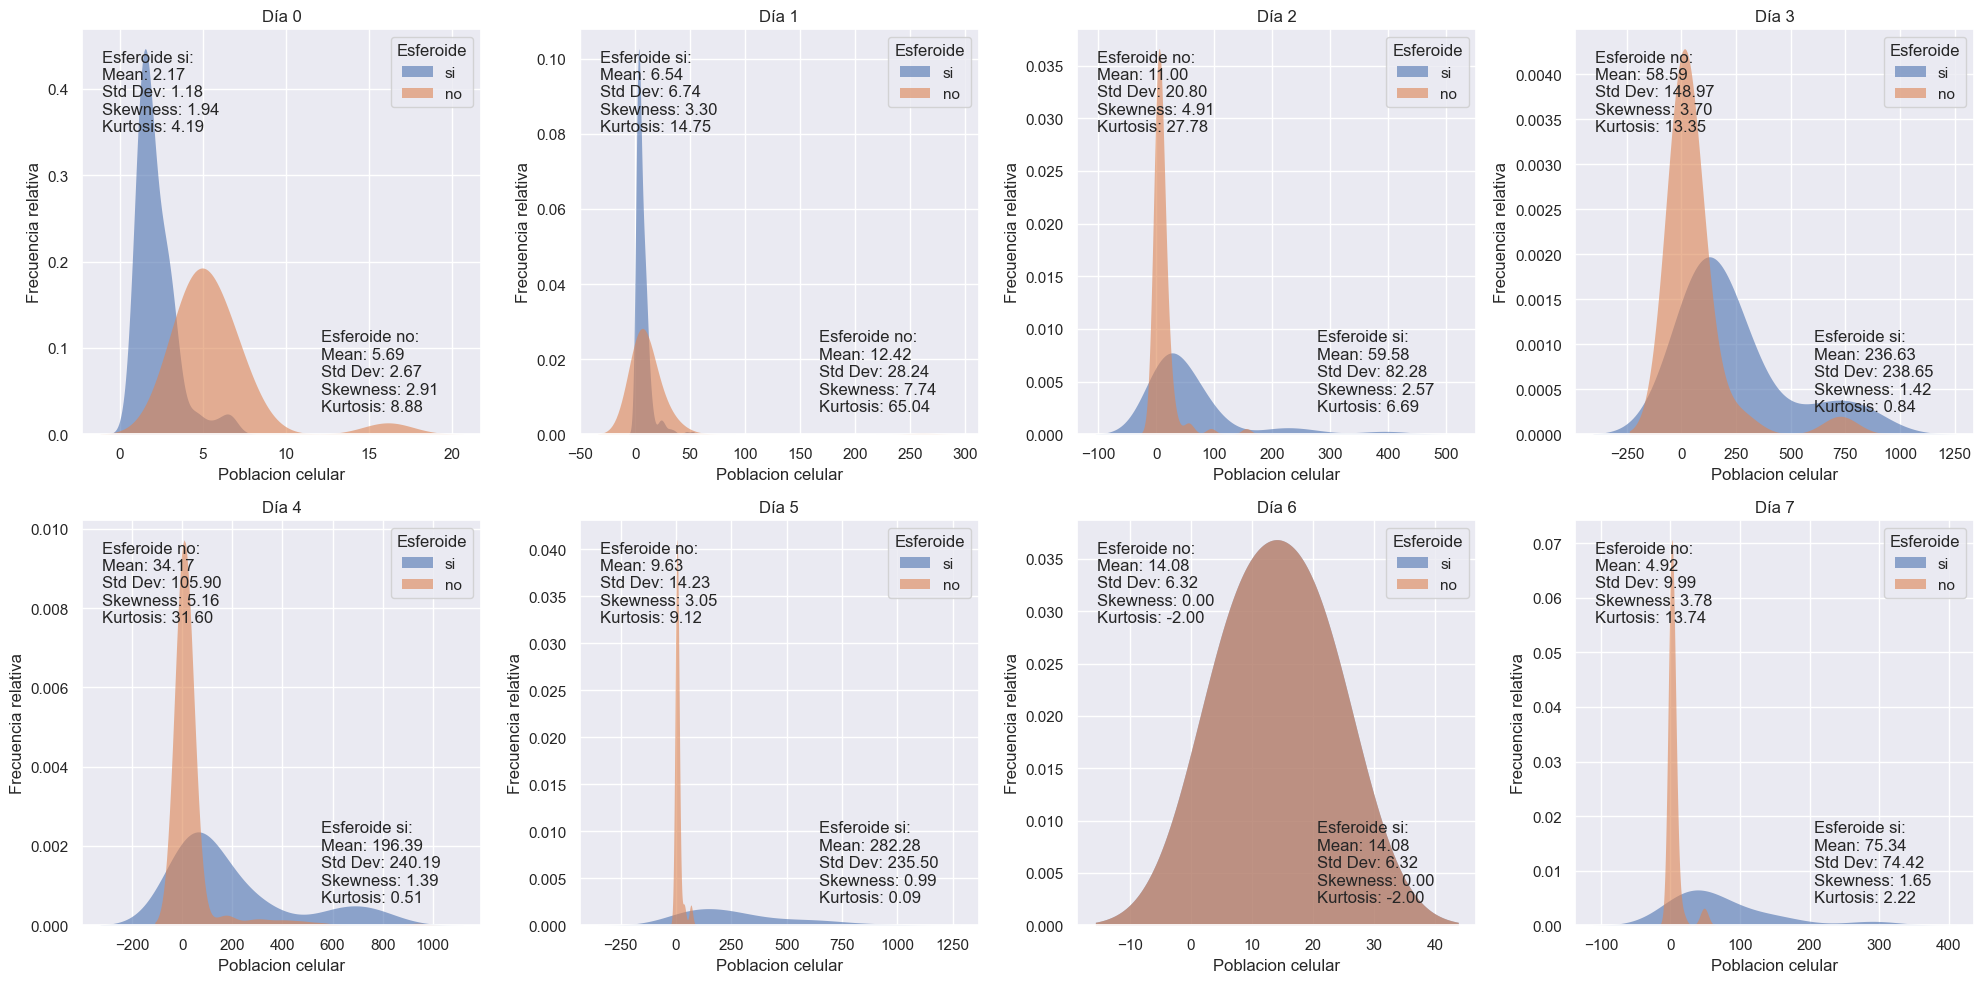

In [245]:
esferoides = df['esferoide'].unique()
dias = df['dia'].unique()

fig, axs = plt.subplots(2, 4, figsize=(20,10)) # Change the figsize values as needed
axs = axs.ravel()

# Upper left and lower right
text_positions = {'si': (0.6, 0.05), 'no': (0.05, 0.95)}  
vertical_alignments = {'si': 'bottom', 'no': 'top'}

# Exceptions for 'dia' values 0 and 1 (because of how distributions ended up)
text_positions_exceptions = {'si': (0.05, 0.95), 'no': (0.6, 0.05)} 
vertical_alignments_exceptions = {'si': 'top', 'no': 'bottom'}

for j, dia in enumerate(dias):
    mean_sino = [0,0]
    std_sino = [0,0]
    skew_sino = [0,0]
    kurt_sino =[0,0]
    
    for i, esferoide in enumerate(esferoides):
        # We select the 'si' or 'no' value and specific 'dia'
        subset = df.loc[(df['esferoide'] == esferoide) & (df['dia'] == dia)]
        
        # We plot the distributions
        sns.kdeplot(data=subset, x="poblacion_celular", fill=True, common_norm=False, 
                    palette="crest", alpha=.6, linewidth=0, label=esferoide, ax=axs[j])
        
        # Calculate mean, std, skewness and kurtosis
        mean_sino[i] = np.mean(subset['poblacion_celular'])
        std_sino[i] = np.std(subset['poblacion_celular'])
        skew_sino[i] = skew(subset['poblacion_celular'])
        kurt_sino[i] = kurtosis(subset['poblacion_celular'])
        
        # Select the positions based on 'dia'
        if dia in [0, 1]:
            text_position = text_positions_exceptions[esferoide]
            vertical_alignment = vertical_alignments_exceptions[esferoide]
        else:
            text_position = text_positions[esferoide]
            vertical_alignment = vertical_alignments[esferoide]
        
        # Annotate the results
        stats_text = f"Esferoide {esferoide}:\nMean: {mean_sino[i]:.2f}\nStd Dev: {std_sino[i]:.2f}\nSkewness: {skew_sino[i]:.2f}\nKurtosis: {kurt_sino[i]:.2f}"
        axs[j].text(text_position[0], text_position[1], stats_text, 
                    transform=axs[j].transAxes, verticalalignment=vertical_alignment)

    axs[j].set_xlabel('Poblacion celular')
    axs[j].set_ylabel('Frecuencia relativa')
    axs[j].legend(title='Esferoide')
    axs[j].set_title(f'Día {dia}')

plt.tight_layout()
plt.show()


In [246]:
# Create an empty DataFrame to store the stats

stats_poblacion_df = pd.DataFrame(columns=['dia', 'esferoide', 'mean', 'std', 'skewness', 'kurtosis'])

for dia in dias:
    for esferoide in esferoides:
        # Select the 'si' or 'no' value and specific 'dia'
        subset = df.loc[(df['esferoide'] == esferoide) & (df['dia'] == dia)]
        
        # Calculate mean, std, skewness and kurtosis
        mean = np.mean(subset['poblacion_celular'])
        std = np.std(subset['poblacion_celular'])
        skewness = skew(subset['poblacion_celular'])
        kurt = kurtosis(subset['poblacion_celular'])
        
        # Append the stats to the DataFrame
        stats_poblacion_df = pd.concat([stats_poblacion_df, pd.DataFrame([{'dia': dia, 
                                                      'esferoide': esferoide, 
                                                      'mean': mean, 
                                                      'std': std, 
                                                      'skewness': skewness, 
                                                      'kurtosis': kurt}], 
                                                     columns=['dia', 'esferoide', 'mean', 'std', 'skewness', 'kurtosis'])], 
                             ignore_index=True)

# show the stats_df DataFrame
stats_poblacion_df

,dia,esferoide,mean,std,skewness,kurtosis
0,0,si,2.170202,1.176615,1.935103e+00,4.192384
1,0,no,5.688647,2.672766,2.910692e+00,8.880637
2,1,si,6.535038,6.741778,3.302866e+00,14.753317
3,1,no,12.422297,28.242901,7.743843e+00,65.038528
4,2,si,59.577433,82.284148,2.569867e+00,6.691146
5,2,no,11.000650,20.800244,4.907712e+00,27.784029
6,3,si,236.631639,238.653670,1.418825e+00,0.835965
7,3,no,58.590889,148.968518,3.698903e+00,13.350221
8,4,si,196.388663,240.186957,1.394082e+00,0.513664
9,4,no,34.168947,105.900036,5.160687e+00,31.604076


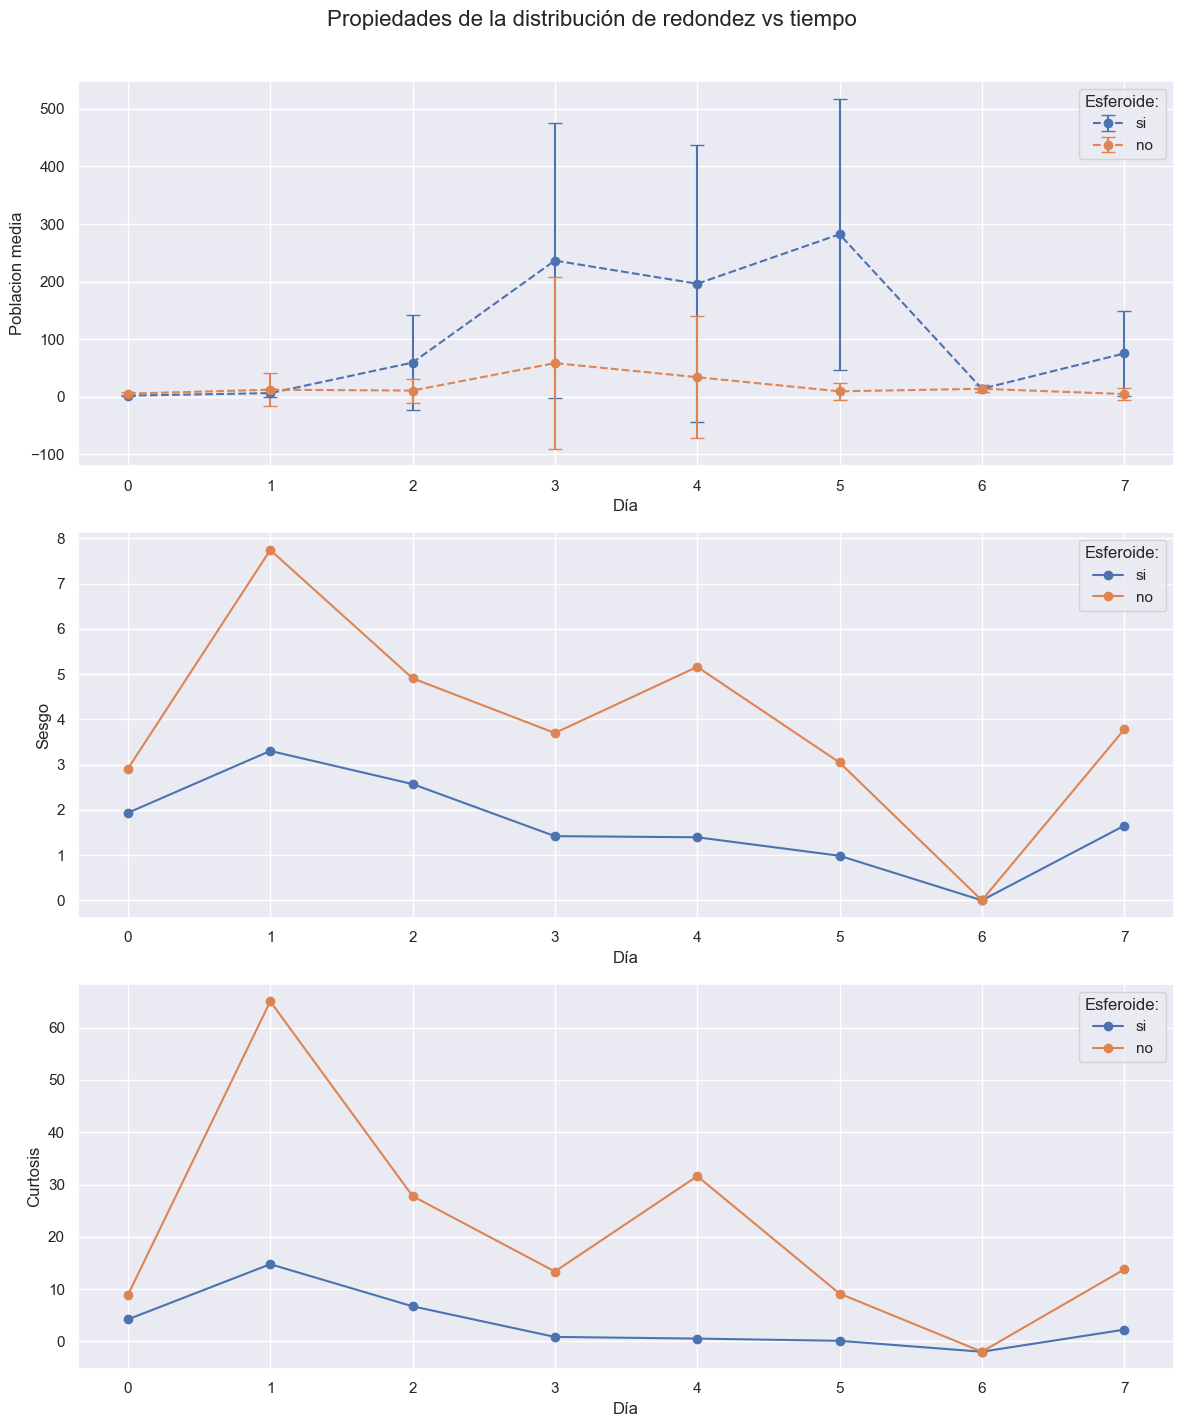

In [247]:
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

#Create a list of the y variables and their corresponding labels
y_vars = [('mean', 'Poblacion media'), ('skewness', 'Sesgo'), ('kurtosis', 'Curtosis')]
  
for i, (y_var, y_label) in enumerate(y_vars):
    for esferoide in esferoides:
        subset = stats_poblacion_df[stats_poblacion_df['esferoide'] == esferoide]
        if y_var == 'mean':
            axs[i].errorbar(x=subset['dia'], y=subset[y_var], yerr=subset['std'], 
                            label=esferoide, fmt='o--', capsize=5)
        else:
            axs[i].plot(subset['dia'], subset[y_var], 'o-', label=esferoide)
        axs[i].set_ylabel(y_label)
        axs[i].set_xlabel('Día')  # Add x-label for each subplot
        axs[i].legend(title='Esferoide:')

fig.suptitle('Propiedades de la distribución de redondez vs tiempo', fontsize=16)  # Add a general title for the whole figure
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust the layout to make room for the title
plt.show()

Al igual que el área, la varible poblacion_celular genera una diferenciación entre esferoides. 

Los esferoides no, presenta distribuciones centradas en cero, con una media de población menor que la de esferoides=si y aproximadamente constante. Se puede concluir que los esferoides=no, no prosperan o prosperan muy lentamente.

Por el contrario, la distribución de esferoides= si, comienza centrada en cero, pero crece con el correr de los días, al igual que la media de la población. Lo que indica que en este caso la tasa de reproducción es más alta.

También la curtosis y el sesgo se diferencia entre esferoides, lo que nos permitiría concluir que la variable es apta para la clasificación de esferoides.

#### Análisis de los datos diarios. 

De acuerdo a los gráficos mostrados anteriormente, por un lado decidimos eliminar del df el día 6 dado que no posee datos suficientes para el análisis requerido. Además, el día 7, no tiene una cantidad de datos grande y además parece alejarse de la tendencia de los días anterirores. Siendo que tampoco conocemos la tendencia del día 6, decidimos que el día 7 tampoco será considerado en los próximos puntos.

In [248]:
df = df.drop(df[(df['dia'] == 6) | (df['dia'] == 7)].index)

### e) probabilidad redondez

¿La probabilidad de que la redondez ('Round') sea mayor a 0.9 en los clasificados como Esferoides = si es mayor que los clasificados como Esferoides = no?.

In [249]:
# Filtro según esferoide sí o no
esferoides_si = df[df['esferoide'] == 'si']
esferoides_no = df[df['esferoide'] == 'no']

# Calculo la cantidad de esferoides sí y de esferoides no
tot_si = len(esferoides_si)
tot_no = len(esferoides_no)

# Filtro aquellos esferoides si y aquellos no, cuya redondez sea mayor a 0.9 y luego
cant_redondez_si = (esferoides_si['redondez'] > 0.9).sum()
cant_redondez_no = (esferoides_no['redondez'] > 0.9).sum()

# Calculo la probabilidad para cada conjunto
prob_redondez_si = round(cant_redondez_si*100/tot_si, 2)
prob_redondez_no = round(cant_redondez_no*100/tot_no, 2)

print("La probabilidad de que redondez sea mayor a 0.9 para Esferoides= si es:", prob_redondez_si, "%")
print("La probabilidad de que redondez sea mayor a 0.9 para Esferoides= no es:", prob_redondez_no, "%")

La probabilidad de que redondez sea mayor a 0.9 para Esferoides= si es: 55.4 %
La probabilidad de que redondez sea mayor a 0.9 para Esferoides= no es: 35.63 %


Como era de esperarse, es más probable que un esferoide sí adquiera una redondez que se aproxima a la unidad que aquellos esferoides no.

Veamos qué sucede con la probabilidad si analizamos las muestras por día.

In [250]:
# Crear un diccionario para almacenar las probabilidades por día
probabilidad_por_dia = {}

# Itero por cada día
for dia in range(6):
    # Filtrar los datos por día para esferoides sí y calcular la cantidad de esferoides sí totales
    esferoides_si_dia = esferoides_si[esferoides_si['dia']==dia]
    tot_si_dia = len(esferoides_si_dia)

    # Filtrar los datos por día para esferoides no y calcular la cantidad de esferoides no totales
    esferoides_no_dia = esferoides_no[esferoides_no['dia']==dia]
    tot_no_dia = len(esferoides_no_dia)

    # Calcular la cantidad de esferoides sí y esferoides no, con redondez mayor a 0.9
    cant_redondez_si_dia = (esferoides_si_dia['redondez']>0.9).sum()
    cant_redondez_no_dia = (esferoides_no_dia['redondez'] >0.9).sum()

    # Calcular la probabilidad para cada conjunto en el día actual
    prob_redondez_si_dia = round(cant_redondez_si_dia*100/tot_si_dia, 2) if tot_si_dia != 0 else 0
    prob_redondez_no_dia = round(cant_redondez_no_dia*100/tot_no_dia, 2) if tot_no_dia != 0 else 0

    # Almacenar las probabilidades en el diccionario por día
    probabilidad_por_dia[dia] = {'prob_redondez_si': prob_redondez_si_dia, 'prob_redondez_no': prob_redondez_no_dia}

for dia, prob in probabilidad_por_dia.items():
    print(f"Para el día {dia}, P(redondez > 0.9) para Esferoides=si es: {prob['prob_redondez_si']}%")
    print(f"Para el día {dia}, P(redondez > 0.9) para Esferoides=no es: {prob['prob_redondez_no']}%")
    print()

Para el día 0, P(redondez > 0.9) para Esferoides=si es: 89.19%
Para el día 0, P(redondez > 0.9) para Esferoides=no es: 0.0%

Para el día 1, P(redondez > 0.9) para Esferoides=si es: 50.99%
Para el día 1, P(redondez > 0.9) para Esferoides=no es: 24.72%

Para el día 2, P(redondez > 0.9) para Esferoides=si es: 40.0%
Para el día 2, P(redondez > 0.9) para Esferoides=no es: 32.94%

Para el día 3, P(redondez > 0.9) para Esferoides=si es: 44.44%
Para el día 3, P(redondez > 0.9) para Esferoides=no es: 36.0%

Para el día 4, P(redondez > 0.9) para Esferoides=si es: 50.0%
Para el día 4, P(redondez > 0.9) para Esferoides=no es: 42.23%

Para el día 5, P(redondez > 0.9) para Esferoides=si es: 60.71%
Para el día 5, P(redondez > 0.9) para Esferoides=no es: 58.33%



Al separar los datos por días, además de clasificarlos según esferoides si o esferoides no, corroboramos que la probabilidad de que redondez > 0.9 es mayor para esferoides si que para esferoides no. Además, podemos observar que a medida que transcurren los días, los esferoides=no comienzan a aumentar su redondez, mientras que los esferoides si, comienzan con un valor de redondez alto, a medida que crecen pierden su forma y luego comienzan a aumentar su redondez nuevamente.

## Ejercicio 4. Exploración de la muestra por día

### a) ¿Cuántos datos hay por día? Hacer gráfico de frecuencias

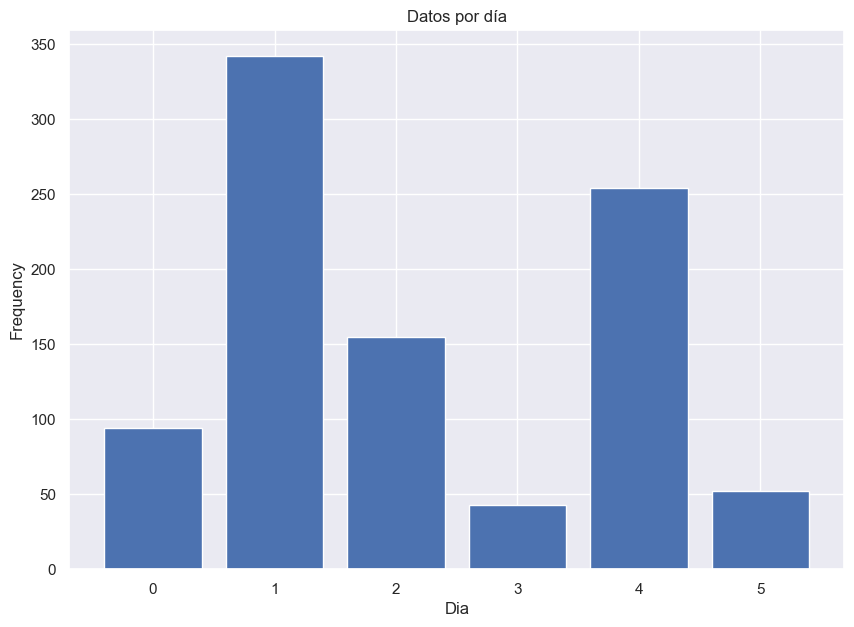

In [251]:
# Agrupamos los datos por día
datos_por_dia = df['dia'].value_counts().sort_index()

# Realizamos un gráfico de frecuencias
plt.figure(figsize=(10, 7))
plt.bar(datos_por_dia.index, datos_por_dia.values)
plt.xlabel('Dia')
plt.ylabel('Frequency')
plt.title('Datos por día')
plt.show()


Del gráfico de frecuencias obserbamos que la cantidad de datos por día es muy dispar, yendo de aproximadamente 350 datos el día 1 hasta alrededor de 50 datos los días 3 y 5. Los análisis realizados para aquellos días con mayor cantidad de datos serán más robustos y representativos de la población que aquellos días con menor cantidad de datos. 

### b) Explorar con diagramas de cajas al menos una columna

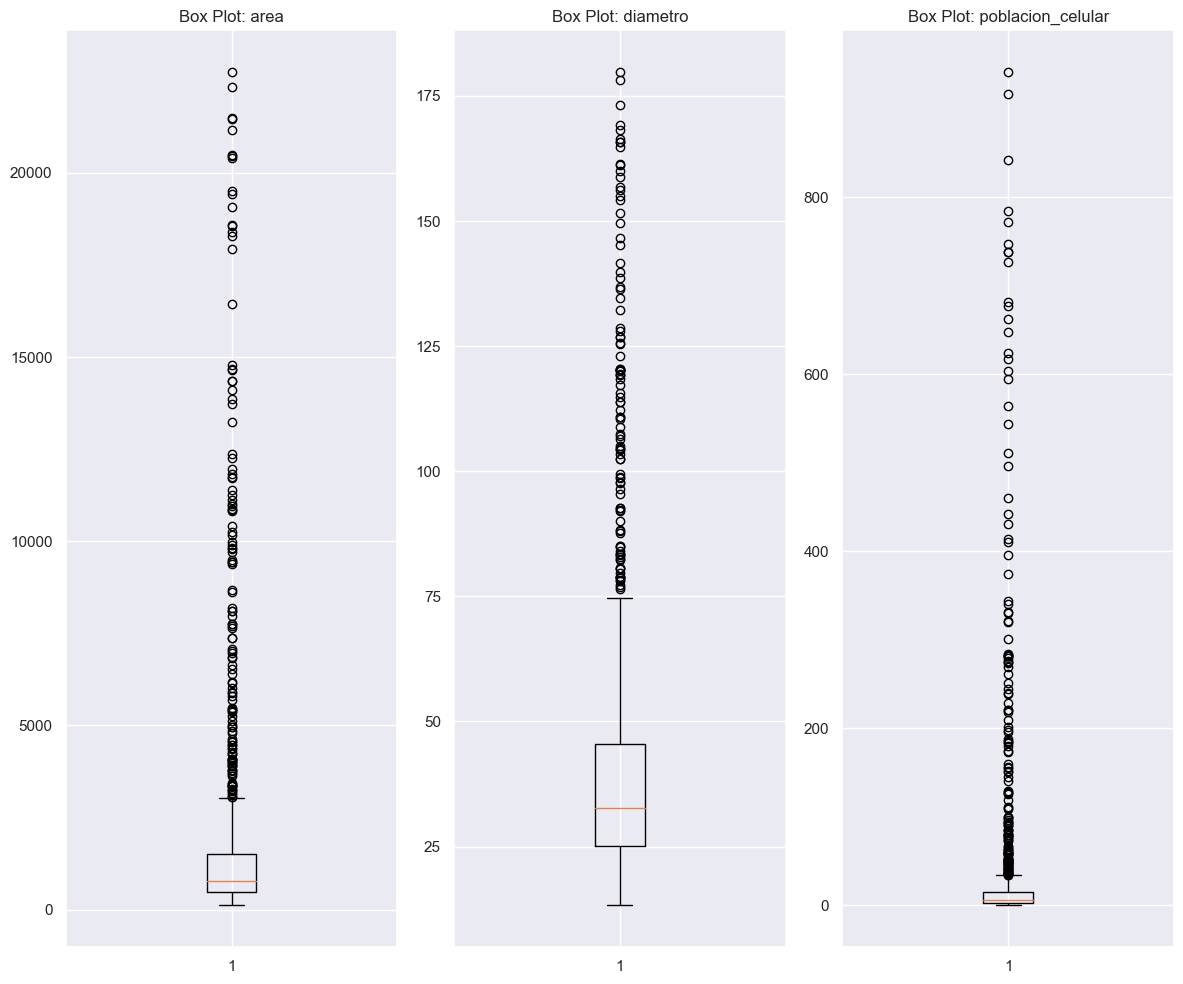

In [253]:
selected_cols = ['area','diametro','poblacion_celular']

# Realizamos el diagrama de cajas para las columnas seleccionadas.
# Dado que las escalas son muy diferentes, hacemos un gráfico por columna

# Ajustamos el tamaño del gráfico en función de la cantidad de columnas
plt.figure(figsize=(4 * len(selected_cols), 10)) 

for i, col in enumerate(selected_cols):
    plt.subplot(1, len(selected_cols), i+1)
    plt.boxplot(df[col])
    plt.title(f'Box Plot: {col}')
     
plt.tight_layout()
plt.show()

Se seleccionaron tres columnas para realizar el gráficos de cajas: area, diametro y poblacion_celular. En los tres casos tenemos gran cantidad de valores atípicos localizados en los extremos superiores de cada columna. 

Eliminar todos estos datos probablemente implicaría una pérdida de información relevante sobre las tumoresferas.

Analicemos a modo de ejemplo el caso de la columna área. Veamos que ocurre si graficaramos un box plot, separando el df según esferoide sí o esferoide no.

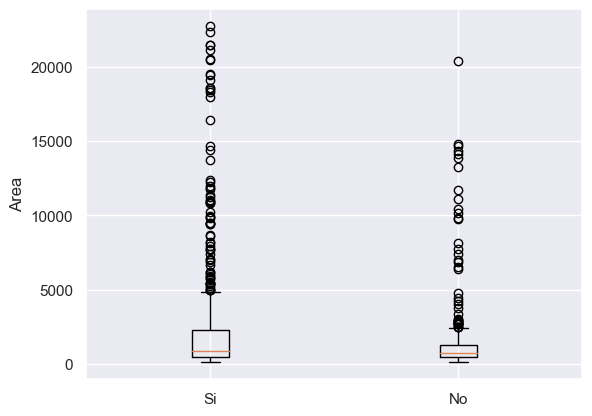

In [254]:
# Separamos el df según sean esferoides o no
esferoide_si = df[df['esferoide'] == 'si']
esferoide_no = df[df['esferoide'] == 'no']

# filtramos por la columna area
area_esferoide_si = esferoide_si['area']
area_esferoide_no = esferoide_no['area']

# graficamos los boxplots
fig, ax = plt.subplots()

ax.boxplot([area_esferoide_si, area_esferoide_no])
ax.set_xticklabels(['Si', 'No'])
ax.set_ylabel('Area')

plt.show()

Del gráfico anterior podemos ver que la distribución de la columna área cambia significativamente al analizar separadamente aquellos datos en donde esferoide = si con aquellos donde esferoide = no. 

Siguiendo con ésta línea, si continuaramos segmentando el df y ahora también filtraramos de acuerdo a la columna 'dia', probablemente cambiaría drásticamente la distribución de cada gráfico. 

De este modo, podemos concluir que se debe ser muy cuidadoso y analizar en profundidad la información que arroja cada columna de manera individual y conjunta antes de eliminar datos atípicos.

Continuemos con el análisis teniendo en cuenta el día. Esto puede resultar imporante dado que un esferoide grande, e.g., uno cuya foto fue tomada en el día 5, podría resultar un outlier cuando consideramos el conjunto total, pero no cuando consideramos específicamente los esferoides del día 5.

In [255]:
def outlier_counter(series_data):
    '''Returns the number of outliers in a pandas.Series.
    '''
    # Calculate Q1, Q3 and IQR
    Q1 = series_data.quantile(0.25)
    Q3 = series_data.quantile(0.75)
    IQR = Q3 - Q1

    # Determine bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify and count outliers
    outlier_count = ((series_data < lower_bound) | (series_data > upper_bound)).sum()
    return outlier_count

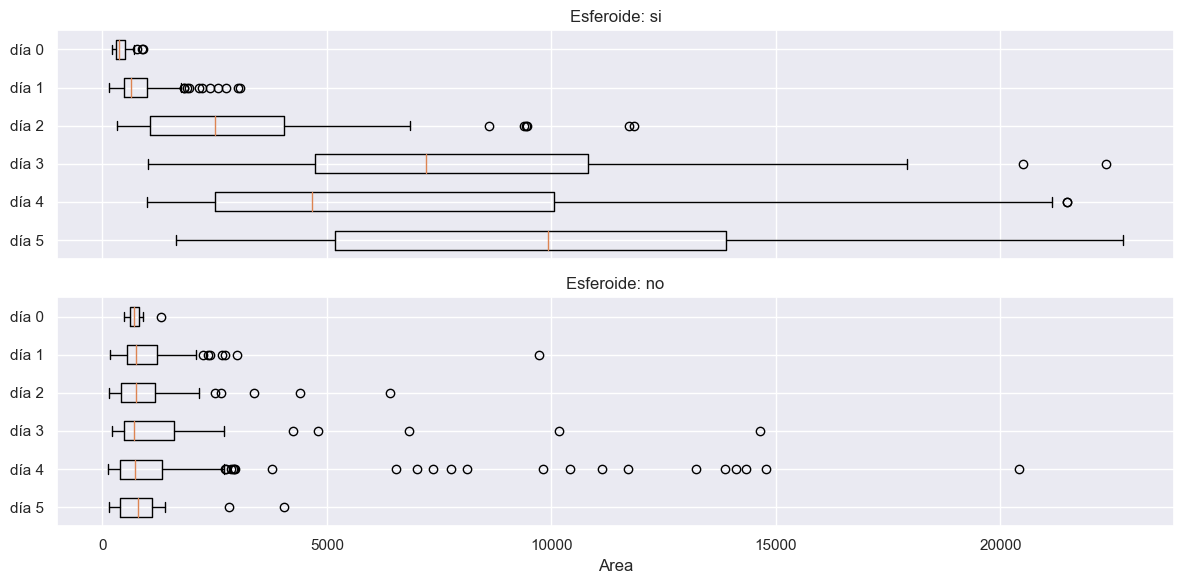

In [256]:
# variables to loop over
esferoides = df['esferoide'].unique()
dias = sorted(df['dia'].unique(), reverse=True)  # sort dias in descending order

# fig to plot
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# dictionary to store outlier counts
outlier_counts = {}

for j, esferoide in enumerate(esferoides):
    # data to plot
    subsets = []
    yticks = []

    # boxplots
    for dia in dias:
        # Select the 'si' or 'no' value and specific 'dia'
        subset = df.loc[(df['esferoide'] == esferoide) & (df['dia'] == dia)]
        
        # we select the area column
        subsets.append(subset['area'])
        
        # we add the y tick
        yticks.append(f'día {dia}')
        
        # Identify and count outliers
        outlier_count = outlier_counter(subset['area'])

        # Store in dictionary and print
        key = (esferoide, dia)
        outlier_counts[key] = outlier_count

    axs[j].boxplot([subsets[i] for i in range(len(subsets))], vert=False)
    axs[j].set_yticklabels([yticks[i] for i in range(len(yticks))])
    axs[j].set_title(f'Esferoide: {esferoide}')

axs[1].set_xlabel('Area')  # Only set x-label for the bottom subplot

plt.tight_layout()
plt.show()

Nuevamente se corrobora que las distribuciones de área difieren bastante según el día, y esto implica diferencias en la presencia de outliers. Veremos en el inciso “d” como se modifica su conteo el tener en cuenta estas categorías.

### c) Descripción de distribuciones por columna
Para la columna elegida en los incisos anteriores (la de área), las distribuciones según las caregorías `esferoide` y `dia` fueron analizadas en el inciso c del ejercicio 3, donde se calcularon propiedades como la asimetría y la kurtosis.

### d) Valores Atípicos (outliers)

Comparemos el número de outliers cuando no discriminamos por categorías, cuando lo hacemos sólo con la categoría esferoide y cuando lo hacemos tanto con la categoría esferoide como con la categoría dia.

In [257]:
# Not taking categories into account
outliers_general_df = outlier_counter(df['area'])
print(f'Cuando no dividimos por categorías tenemos {outliers_general_df} outliers.\n')

# Taking the esferoide category into account
outliers_dividing_by_esferoide = {'si': outlier_counter(area_esferoide_si), 'no': outlier_counter(area_esferoide_no)}
total_outliers_dividing_by_esferoide = outlier_counter(area_esferoide_si) + outlier_counter(area_esferoide_no)
print(f"Cuando sólo dividimos por esferoide sí y no, tenemos {total_outliers_dividing_by_esferoide} outliers: ")
print(f"{outliers_dividing_by_esferoide['si']} de los esferoides sí, y {outliers_dividing_by_esferoide['no']} de los no.\n")

# Taking esferoide and dia into account
new_total_outliers = 0

print(f"Si tenemos en cuenta la categoría esferoide y la categoría día, tenemos:\n")
for esferoide in esferoides:
    for dia in dias:
        print(f"Esferoide '{esferoide}', día {dia}: {outlier_counts[(esferoide, dia)]} outliers.")
        new_total_outliers += outlier_counts[(esferoide, dia)]
        
print(f'\nEsto da un total de {new_total_outliers} outliers.')

Cuando no dividimos por categorías tenemos 130 outliers.

Cuando sólo dividimos por esferoide sí y no, tenemos 111 outliers: 
69 de los esferoides sí, y 42 de los no.

Si tenemos en cuenta la categoría esferoide y la categoría día, tenemos:

Esferoide 'si', día 5: 0 outliers.
Esferoide 'si', día 4: 2 outliers.
Esferoide 'si', día 3: 2 outliers.
Esferoide 'si', día 2: 6 outliers.
Esferoide 'si', día 1: 11 outliers.
Esferoide 'si', día 0: 3 outliers.
Esferoide 'no', día 5: 2 outliers.
Esferoide 'no', día 4: 22 outliers.
Esferoide 'no', día 3: 5 outliers.
Esferoide 'no', día 2: 5 outliers.
Esferoide 'no', día 1: 7 outliers.
Esferoide 'no', día 0: 1 outliers.

Esto da un total de 66 outliers.


Como vemos, al tener en cuenta las categorías de los datos, el número de valores atípicos (outliers) se reduce a la mitad. Esto resulta ser no sólo lo correcto, sino que también preserva más información. La explicación de la mayor preservación de datos es la comentada en el inciso “b” del presente ejercicio.

Notemos que la mayoría de outliers son valores atípicamente altos. Esto quiere decir que se trata de agregados que por algún motivo están siendo mucho más grandes que los demás. Quizás esto se deba a que estos están prosperando mucho más que el resto, quizás sean el resultado de la unión de múltiples agregados, o quizás estamos tomando en cuenta muchos agregados que no están logrando crecer, por lo que los que sí lo logran terminan siendo muy grandes en comparación.

Dependiendo de la explicación de estos valores, el curso a seguir será diferente. Por mencionar un ejemplo, en caso de que los valores atípicos se deban a la fusión de más de un esferoide, podríamos eliminarlos diciendo que no contribuyen a nuestro objetivo de estudiar las propiedades de esferoides monoclonales (si este fuera nuestro objetivo).

### e) La media de los esferoides=*no* al día 3 es igual que al día 5? Realizar Test de Hipótesis. 

En nuestro caso el estadístico que buscamos evaluar es la media de las diferencias entre el día 3 y 5, o lo que es equivalente, su igualdad. La variable a testear es 'poblacion_celular' donde esferoide = no. 

$H_0: u_1 = u_2$

$H_1: u_1 ≠ u_2$

Proponemos un nivel de significancia $(α) = 0.05$

In [258]:
# Filtramos el df según el dia y esferoide= no
df_dia3_no = df[(df['dia'] == 3) & (df['esferoide'] == 'no')]
df_dia5_no = df[(df['dia'] == 5) & (df['esferoide'] == 'no')]

# seleccionamos la columna 'poblacion_celular'
poblacion_dia3_no = df_dia3_no['poblacion_celular']
poblacion_dia5_no = df_dia5_no['poblacion_celular']

#definimos el nivel de significancia
alpha = 0.05

En primer lugar, evaluaremos la posibilidad de aplicar el test de student. Para ello verificaremos los supuesto de normalidad e igualdad de varianzas.

**Test de Shapiro**

Verificamos la normalidad de las distribuciones empleando el test de Shapiro.

In [259]:
shapiro_poblacion_dia3_no = stats.shapiro(poblacion_dia3_no)
shapiro_poblacion_dia5_no = stats.shapiro(poblacion_dia5_no)

if shapiro_poblacion_dia3_no.pvalue >alpha:
    print("la variable población celular al día 3 para esferoides=no, tiene dist normal")
else:
    print("la variable población celular al día 3 para esferoides=no, no tiene dist normal")
    
if shapiro_poblacion_dia5_no.pvalue > alpha:
    print("la variable población celular al día 5 para esferoides=no, no tiene dist normal")
else:
    print("la variable población celular al día 5 para esferoides=no, no tiene dist normal")

la variable población celular al día 3 para esferoides=no, no tiene dist normal
la variable población celular al día 5 para esferoides=no, no tiene dist normal


Las subpoblaciones analizadas no siguen una distribución normal.

El teorema del límite central establece que a medida que aumenta el tamaño de la muestra, la distribución de la media muestral se aproxima a una distribución normal, independientemente de la forma de la distribución de la población. En el caso del test de student para diferencia de medias, cuando los grados de libertad son altos (normalmente por encima de 30), el test es válido y confiable, incluso si las poblaciones no siguen una distribución normal.

In [260]:
# Verificamos si grados de libertad> 30 para evaluar si es posible aplicar el teorema central del límite (TCL)
len_dia3 = len(poblacion_dia3_no)
len_dia5 = len(poblacion_dia5_no)

grados_de_libertad = (len_dia3-1) + (len_dia5-1)
grados_de_libertad

47

Dado que los grados de libertad son mayores a 30, aproximaremos por distribución normal.

**Test de Levene para homogeneidad de varianzas**

Verificaremos a continuación la homogeneidad de varianzas para verificar los supuestos del test de student.

In [264]:
stat, pval = levene(poblacion_dia3_no, poblacion_dia5_no)

print(f"Levene's test statistic: {stat:.3f}")
print(f"P-value: {pval:.3f}")
if pval > alpha:
    print("varianzas homogéneas")
else:
    print("varianzas no homogéneas")

Levene's test statistic: 2.471
P-value: 0.123
varianzas homogéneas


Dado que las varianzas son homogéneas, continuaremos el ejercicio con el test de student para igualdad de medias de dos poblaciones.

**Test de Student para la diferencia de medias**

In [266]:
t_statistic, p_value = stats.ttest_ind(poblacion_dia3_no, poblacion_dia5_no, equal_var=True)

print(f"Student test statistic: {t_statistic:.3f}")
print(f"P-value: {p_value:.3f}")
if pval > alpha:
    print("Se acepta la hipótesis nula")
else:
    print("Se rechaza la hipótesis nula")

Student test statistic: 1.570
P-value: 0.123
Se acepta la hipótesis nula


Dado que el p-valor > alpha (nivel de significación), se acepta la hipótesis nula y se concluye que las medias entre las subpoblaciones analizadas son aproximadamente iguales.

### f) Determinen el intervalo de confianza diario de tal(es) columna(s) para las clasificadas como *'Esferoide'*=**'si'**. Y exploren como utilizarlos como barras de error en el gráfico. 

Seguiremos trabajando con la columna 'poblacion_celular'. Ahora filtraremos nuestro dataframe según esferoides=='si', y analizaremos el intervalo de confianza para cada dia.

En una primer instancia calcularemos el intervalo de confianza, IC, de manera analítica y luego lo visualizaremos gráficamente.

In [267]:
#Filtro el df según esferoide= 'si'
df_esferoide_si = df[df['esferoide'] == 'si']

# Agrupo los datos según dia
df_esferoide_si_dia = df_esferoide_si.groupby('dia')

# Calcular la media y el intervalo de confianza para "poblacion_celular" en cada grupo
IC = df_esferoide_si_dia['poblacion_celular'].apply(lambda x: stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x)))

# redondeo de decimales
IC = IC.apply(lambda x: [round(val, 2) for val in x])

for dia, intervalo in IC.iteritems():
    print(f"Día {dia}: {intervalo}")

Día 0: [1.9, 2.44]
Día 1: [5.7, 7.37]
Día 2: [39.82, 79.34]
Día 3: [114.51, 358.75]
Día 4: [125.91, 266.87]
Día 5: [189.28, 375.27]


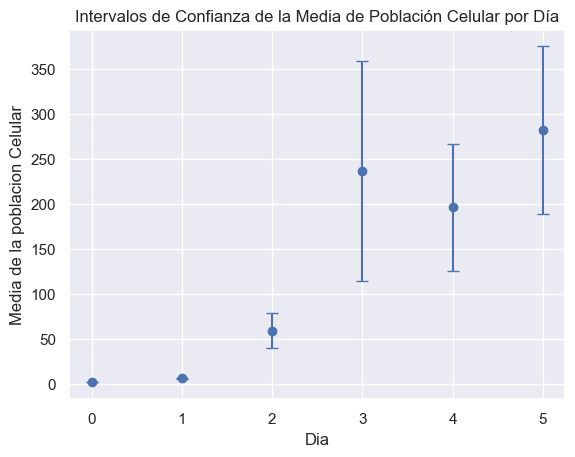

In [269]:
# Calcular la media y el intervalo de confianza para "poblacion_celular" en cada grupo

mean_dias = df_esferoide_si_dia['poblacion_celular'].mean()

# Obtener los límites del intervalo de confianza
lower = [intervalo[0] for intervalo in IC]
upper = [intervalo[1] for intervalo in IC]

# Crear el gráfico con barras de error
plt.errorbar(mean_dias.index, mean_dias.values, yerr=[mean_dias-lower, upper-mean_dias], fmt='o', capsize=4)

plt.xlabel('Dia')
plt.ylabel('Media de la poblacion Celular')
plt.title('Intervalos de Confianza de la Media de Población Celular por Día')
plt.grid(True)

plt.show()


Podemos observar tanto del calculo de IC para cada día como del gráfico, que desde el día 0 al día 3, la población celular aumenta. A partir del día 3 hasta el día 5, dado que los intervalos de confianza se solapan entre sí, podemos asumir que la población celular se mantiene constante. 

Por otro lado, a medida que pasan los días, parecería ir aumentando la dispersión de los datos. Para evaluar esto, calcularemos el cuánto se aleja el límite superior de cada intervalo de confianza de la media.

In [270]:
# Cálculo de desviación porcentual de la media por día
desviacion_porcentual = {}
for dia, intervalo in IC.items():
    media = (intervalo[0] + intervalo[1]) / 2
    desviacion = ((intervalo[1] - media) / media) * 100
    desviacion_porcentual[dia] = desviacion

for dia, desviacion in desviacion_porcentual.items():
    print(f"Día {dia}: {desviacion:.2f}%")

Día 0: 12.44%
Día 1: 12.78%
Día 2: 33.17%
Día 3: 51.61%
Día 4: 35.89%
Día 5: 32.94%


De esta manera, corroboramos que a medida que aumentan los días, la dispersión aumenta. Esto puede deberse a que cada tumoresfera tiene una tasa de crecimiento diferente y esta diferencia se va haciendo más evidente a medida que pasan los días.